In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import fiona
from fiona.crs import from_epsg
import os
from sklearn.preprocessing import MinMaxScaler

In [2]:
# load county and road shapefile
gc = gpd.read_file("data/tl_2017_06_cousub/tl_2017_06_cousub.shp")
gr = gpd.read_file("data/National_Highway_System/National_Highway_System.shp")

In [128]:
gc = gc.to_crs(epsg=3310)
gr = gr.to_crs(epsg=3310)

In [20]:
exclude_county = ['015', '023', '033', '045', # district 1
                  '049', '035', '063', '089', '093', '105', # district 2
                  '027', '051'] # district 9

In [175]:
dslv_county = gc[gc['COUNTYFP'].notna()].dissolve(by='COUNTYFP', aggfunc='sum')

In [176]:
dslv_county = dslv_county.reset_index()
dslv_county = dslv_county.rename(columns={"index": "COUNTYFP"})

In [132]:
# dslv_county = dslv_county[~dslv_county.COUNTYFP.isin(exclude_county)]

In [177]:
dslv_county.to_file('data/geo_res/filtered_counties_full.shp')

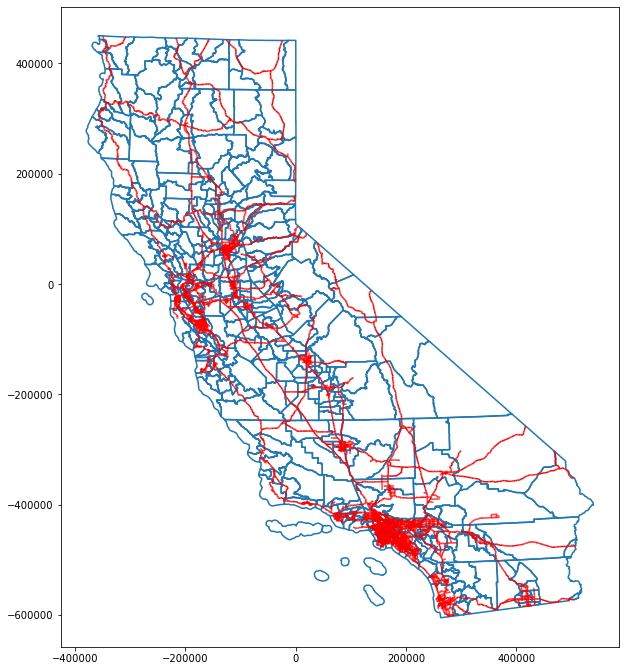

In [135]:
ax = gc.boundary.plot(figsize=(10, 12))
gr.plot(color='r', ax=ax)

In [136]:
# merge roads with the same route_id
dslv_road = gr[gr['ROUTEID'].notna()][['ROUTEID', 'Shape_Leng', 'geometry']].dissolve(by='ROUTEID', aggfunc='sum')

In [178]:
inter_county = pd.DataFrame(columns=dslv_road.columns) # store inter-county roads
link_county = [] # store list of counties linked by a road
for ind, line in dslv_road.iterrows():
    county = dslv_county[dslv_county['geometry'].intersects(line['geometry'])]
    if len(county) > 1:
        inter_county = inter_county.append(line)
        link_county.append(county)

In [179]:
ic = inter_county.reset_index()
ic = ic.rename(columns={"index": "ROUTEID"})
gic = gpd.GeoDataFrame(ic, crs=gr.crs, geometry='geometry')

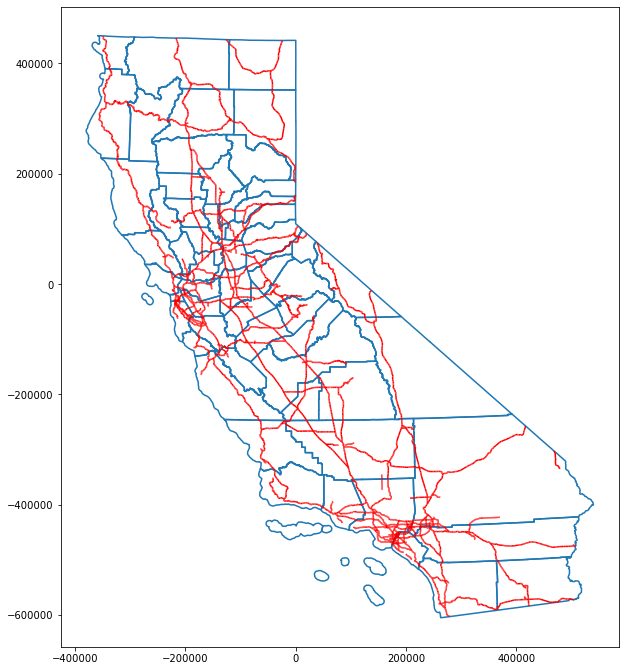

In [180]:
ax = dslv_county.boundary.plot(figsize=(10, 12))
gic.plot(color='r', ax=ax)

In [181]:
gic.to_file('data/geo_res/major_roads_full.shp')

In [182]:
dslv_county = dslv_county.sort_values(by=['COUNTYFP'])

In [183]:
len(dslv_county)

58

In [77]:
def scaler(data):
    scaler = data.max().max()
    print(scaler)
    return data/scaler

In [184]:
############ adjacent matrix from road, weighted by distance ############
adj_by_road = pd.DataFrame(np.zeros((len(dslv_county), len(dslv_county))), \
                             columns=dslv_county['COUNTYFP'], index=dslv_county['COUNTYFP'])
for link in link_county:
    for ind, county in link.iterrows():
        for _, neighbor in link.iterrows():
            dst = county['geometry'].distance(neighbor['geometry']) + 1000.
            adj_by_road[county['COUNTYFP']][neighbor['COUNTYFP']] = 1000./dst
adj_by_road = scaler(adj_by_road)  
np.save('data/adj_by_road_full.npy', adj_by_road, allow_pickle=True)

1.0


In [185]:
############ adjacent matrix from adjacency ############
adj_by_county = pd.DataFrame(np.zeros((len(dslv_county), len(dslv_county))), \
                             columns=dslv_county['COUNTYFP'], index=dslv_county['COUNTYFP'])
for ind, county in dslv_county.iterrows():   
    # get 'disjoint' countries
    neighbors = dslv_county[~dslv_county.geometry.disjoint(county.geometry)]
    for _, neighbor in neighbors.iterrows():
        adj_by_county[county['COUNTYFP']][neighbor['COUNTYFP']] = 1
np.save('data/adj_by_county_full.npy', adj_by_county, allow_pickle=True)

In [186]:
adj_mat = scaler(adj_by_county + adj_by_road)
np.save('data/adj_mat_full.npy', adj_mat, allow_pickle=True)

2.0


In [12]:
############ separate detectors (inter-county/local) ############
path = 'data/pems'
files = [] # list of files with detector locations
for i in os.listdir(path):
    if os.path.isfile(os.path.join(path, i)) and i.find('meta') != -1:
        files.append(i)

In [161]:
md_buff = gic.geometry.buffer(50) # 50m buffer of major roads
md_buff = md_buff.unary_union
len(md_buff)

28

In [166]:
dt_ic = gpd.GeoDataFrame() # inter county detectors
dt_lc = gpd.GeoDataFrame() # local detectors
for i in files:
    print(i)
    df = pd.read_csv(os.path.join(path, i), header=0, sep='\t')
    dt_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
    dt_gdf = dt_gdf[dt_gdf.geometry.notnull()]
    dt_gdf.crs = {'init': 'epsg:4326'}
    dt_gdf = dt_gdf.to_crs(epsg=3310)
    
    dt_ic = dt_ic.append(dt_gdf[dt_gdf.within(md_buff)], ignore_index = True)
    dt_lc = dt_lc.append(dt_gdf[~dt_gdf.within(md_buff)], ignore_index = True)
#     break
dt_ic = dt_ic.to_crs(epsg=3310)
dt_lc = dt_lc.to_crs(epsg=3310)

d03_text_meta_2020_01_30.txt


C:\Users\yansh\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


d04_text_meta_2020_12_03.txt


C:\Users\yansh\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


d05_text_meta_2020_08_28.txt


C:\Users\yansh\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


d06_text_meta_2020_11_13.txt


C:\Users\yansh\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


d07_text_meta_2020_11_16.txt


C:\Users\yansh\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


d08_text_meta_2020_12_24.txt


C:\Users\yansh\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


d10_text_meta_2020_09_15.txt


C:\Users\yansh\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


d11_text_meta_2020_10_02.txt


C:\Users\yansh\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


d12_text_meta_2020_09_19.txt


C:\Users\yansh\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [167]:
dt_ic.to_file('data/geo_res/ic_detectors.shp')
dt_lc.to_file('data/geo_res/lc_detectors.shp')

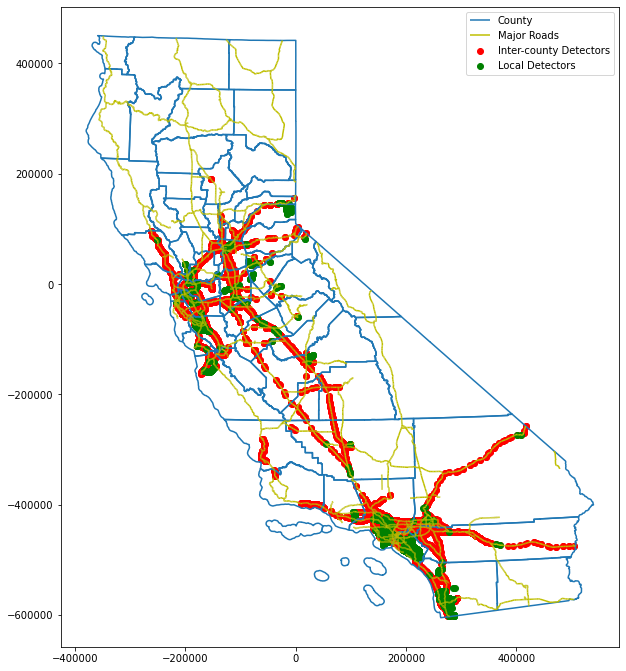

In [187]:
ax = dslv_county.boundary.plot(figsize=(10, 12))
gic.plot(color='y', ax=ax)
dt_ic.plot(color='r', ax=ax)  
dt_lc.plot(color='g', ax=ax) 
ax.legend(["County", "Major Roads", "Inter-county Detectors", "Local Detectors"])

In [192]:
dt_ic[['ID', 'Dir', 'County']].to_csv('data/tmp/dt_ic.csv')
dt_lc[['ID', 'Dir', 'County']].to_csv('data/tmp/dt_lc.csv')

In [4]:
############ aggregate detector information ############
dt_ic_ids = pd.read_csv('data/tmp/dt_ic.csv', header=0, index_col=0)
dt_lc_ids = pd.read_csv('data/tmp/dt_lc.csv', header=0, index_col=0)

In [75]:
dt_lc_ids['County'].unique().shape

(30,)

In [7]:
path = 'data/pems'
files = []
for i in os.listdir(path):
    if os.path.isfile(os.path.join(path, i)) and i.find('station') != -1:
        files.append(i)

files = sorted(files)

In [148]:
ic_summary, lc_summary = [], []
for i in files:
    # inter county
    _df = pd.read_csv(os.path.join(path, i), header=None)
    tmp = _df.join(dt_ic_ids.set_index('ID'), on=1)[[0, 1, 9, 'Dir', 'County']]
    tmp = tmp[:][~tmp['County'].isna()] # remove detectors without county
    tmp['County'] = tmp['County'].apply(int)
    ic_summary.append(tmp)
    
    # local county
    tmp = _df.join(dt_lc_ids.set_index('ID'), on=1)[[0, 1, 9, 'Dir', 'County']]
    tmp = tmp[:][~tmp['County'].isna()] # remove detectors without county
    tmp['County'] = tmp['County'].apply(int)
    lc_summary.append(tmp)

In [149]:
len(ic_summary)

36

In [150]:
lc_smm = pd.concat(lc_summary)
ic_smm = pd.concat(ic_summary)
print(lc_smm.shape, ic_smm.shape)
print(lc_smm.head())

(361359, 5) (1823035, 5)
                      0       1        9 Dir  County
88  02/01/2020 00:00:00  312689  63553.0   N      67
89  02/01/2020 00:00:00  312692      NaN   N      67
90  02/01/2020 00:00:00  312694  71843.0   N      67
91  02/01/2020 00:00:00  312706      NaN   N      67
92  02/01/2020 00:00:00  312709   8860.0   N      67


In [151]:
lc_smm = lc_smm.groupby(['County', 0, 'Dir'])[9].describe()
ic_smm = ic_smm.groupby(['County', 0, 'Dir'])[9].describe()

In [152]:
lc_smm.head()

count          mean           std      min  \
County 0                   Dir                                               
1      02/01/2020 00:00:00 E     22.0  57785.818182  40360.211835   6063.0   
                           N     10.0  47290.900000  28838.782889   4097.0   
                           S     12.0  53341.000000  20995.345649   4846.0   
                           W     12.0  65877.250000  37457.180858  12912.0   
       02/02/2020 00:00:00 E     22.0  51554.954545  40238.143158   1067.0   

                                     25%      50%        75%       max  
County 0                   Dir                                          
1      02/01/2020 00:00:00 E    30821.00  45785.0   98408.25  129377.0  
                           N    29394.50  49388.0   72562.00   81865.0  
                           S    48911.25  55117.0   66338.75   79473.0  
                           W    39695.50  58392.0  106605.25  122615.0  
       02/02/2020 00:00:00 E    19419.00  37671.5   95329.75  108300.0

In [44]:
mb = pd.read_csv('data/2020_US_Region_Mobility_Report.csv', header=0)\
                [(mb['sub_region_1'] == 'California') & (mb['sub_region_2'].notna())]
mb.head()

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
58491,US,United States,California,Alameda County,NaN,NaN,6001.0,ChIJWRd5NDfyj4ARc30TGxHHxmg,2020-02-15,1.0,0.0,22.0,1.0,0.0,-1.0
58492,US,United States,California,Alameda County,NaN,NaN,6001.0,ChIJWRd5NDfyj4ARc30TGxHHxmg,2020-02-16,7.0,0.0,24.0,5.0,1.0,-2.0
58493,US,United States,California,Alameda County,NaN,NaN,6001.0,ChIJWRd5NDfyj4ARc30TGxHHxmg,2020-02-17,13.0,1.0,55.0,-31.0,-53.0,11.0
58494,US,United States,California,Alameda County,NaN,NaN,6001.0,ChIJWRd5NDfyj4ARc30TGxHHxmg,2020-02-18,-2.0,3.0,21.0,3.0,0.0,0.0
58495,US,United States,California,Alameda County,NaN,NaN,6001.0,ChIJWRd5NDfyj4ARc30TGxHHxmg,2020-02-19,-1.0,0.0,14.0,1.0,0.0,0.0


In [45]:
mb['census_fips_code'] = (mb['census_fips_code']%6000).apply(int)

In [183]:
mb_f = mb[(mb['date']>='2020-02-01') & (mb['date']<='2020-05-31')]
mb_f[:]['date'] = mb_f[:]['date'].str.split('-').apply(lambda x: '/'.join([x[1], x[2], x[0]]))
mb_f.head()

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
58491,US,United States,California,Alameda County,NaN,NaN,1,ChIJWRd5NDfyj4ARc30TGxHHxmg,02/15/2020,1.0,0.0,22.0,1.0,0.0,-1.0
58492,US,United States,California,Alameda County,NaN,NaN,1,ChIJWRd5NDfyj4ARc30TGxHHxmg,02/16/2020,7.0,0.0,24.0,5.0,1.0,-2.0
58493,US,United States,California,Alameda County,NaN,NaN,1,ChIJWRd5NDfyj4ARc30TGxHHxmg,02/17/2020,13.0,1.0,55.0,-31.0,-53.0,11.0
58494,US,United States,California,Alameda County,NaN,NaN,1,ChIJWRd5NDfyj4ARc30TGxHHxmg,02/18/2020,-2.0,3.0,21.0,3.0,0.0,0.0
58495,US,United States,California,Alameda County,NaN,NaN,1,ChIJWRd5NDfyj4ARc30TGxHHxmg,02/19/2020,-1.0,0.0,14.0,1.0,0.0,0.0


In [180]:
'/'.join([_s[1], _s[2], _s[0]])

'05/31/2020'

In [184]:
###### load new cases ######
_df = pd.read_csv('data/covid-19-data-master/us-counties.csv', header=0)
_df = _df[(_df['state'] == 'California') & (_df['date']>='2020-02-01') & (_df['date']<='2020-05-31') & (_df['fips'].notna())]
_df['fips'] = (_df['fips']%6000).apply(int)
_df['date'] = _df['date'].str.split('-').apply(lambda x: '/'.join([x[1], x[2], x[0]]))
_df.head()

,date,county,state,fips,cases,deaths
40,02/01/2020,Los Angeles,California,37,1,0.0
41,02/01/2020,Orange,California,59,1,0.0
42,02/01/2020,Santa Clara,California,85,1,0.0
47,02/02/2020,Los Angeles,California,37,1,0.0
48,02/02/2020,Orange,California,59,1,0.0


In [91]:
print(_df['date'].unique().shape, _df['fips'].unique().shape)

(121,) (57,)


In [116]:
# indices for counties and dates
dates = lc_smm.index.get_level_values(0).unique().str[:10].sort_values()
cfips = pd.read_csv('data/list of county.txt', header=None)[2].sort_values()
dirs = ['E', 'N', 'S', 'W']

In [191]:
print(lc_smm[lc_smm.index.get_level_values(0).isna()],ic_smm[ic_smm.index.get_level_values(0).isna()])
print(lc_smm[lc_smm.isna()].shape,ic_smm[ic_smm.isna()].shape,mb_f[mb_f.isna()].shape,_df[_df.isna()].shape)

Empty DataFrame
Columns: [count, mean, std, min, 25%, 50%, 75%, max]
Index: [] Empty DataFrame
Columns: [count, mean, std, min, 25%, 50%, 75%, max]
Index: []
(9075, 8) (16819, 8) (5941, 15) (4424, 6)


In [192]:
inputs, labels = np.zeros((121, 58, 86)), np.zeros((121, 58)) 
# n_days*n_counties*n_attributes
# 86 = lc[(4 directions + no direction)*(8 summary)]
#    + ic[(4 directions + no direction)*(8 summary)]
#    + 6 mobility attribute

for id, d in enumerate(dates):
    for ic, c in enumerate(cfips):
        # fill in inputs lc
        tmp = lc_smm[(lc_smm.index.get_level_values(0).str.contains(d))&(lc_smm.index.get_level_values('County')==c)]
        if not tmp.empty:
            for idr, dr in enumerate(dirs):
                if not tmp[tmp.index.get_level_values('Dir')==dr].empty:
                    for icol, col in enumerate(tmp.columns):
                        inputs[id, ic, idr*8+icol] = tmp.iloc[tmp.index.get_level_values('Dir')==dr][col]
            if not tmp[tmp.index.get_level_values('Dir').isna()].empty:
                for icol, col in enumerate(tmp.columns):
                    inputs[id, ic, 4*8+icol] = tmp.iloc[tmp.index.get_level_values('Dir').isna()][col]
                
        # fill in inputs ic
        tmp = ic_smm[(ic_smm.index.get_level_values(0).str.contains(d))&(ic_smm.index.get_level_values('County')==c)]
        if not tmp.empty:
            for idr, dr in enumerate(dirs):
                if not tmp[tmp.index.get_level_values('Dir')==dr].empty:
                    for icol, col in enumerate(tmp.columns):
                        inputs[id, ic, 40+idr*8+icol] = tmp.iloc[tmp.index.get_level_values('Dir')==dr][col]
            if not tmp[tmp.index.get_level_values('Dir').isna()].empty:
                for icol, col in enumerate(tmp.columns):
                    inputs[id, ic, 40+4*8+icol] = tmp.iloc[tmp.index.get_level_values('Dir').isna()][col]
                
        # fill in inputs mobility
        tmp = mb_f[(mb_f['date']==d)&(mb_f['census_fips_code']==c)]
        if not tmp.empty:
            for icol, col in enumerate(tmp.columns[-6:]):
#                 print(col, tmp.iloc[0][col])
                inputs[id, ic, 80+icol] = tmp.iloc[0][col]
        
        # fill labels
        if not _df[(_df['date']==d)&(_df['fips']==c)].empty:
            labels[id][ic] = _df[(_df['date']==d)&(_df['fips']==c)].iloc[0]['cases']

retail_and_recreation_percent_change_from_baseline 1.0
grocery_and_pharmacy_percent_change_from_baseline 0.0
parks_percent_change_from_baseline 22.0
transit_stations_percent_change_from_baseline 1.0
workplaces_percent_change_from_baseline 0.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 13.0
grocery_and_pharmacy_percent_change_from_baseline 2.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -3.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline 4.0
grocery_and_pharmacy_percent_change_from_baseline 5.0
parks_percent_change_from_baseline 28.0
transit_stations_percent_change_from_baseline -4.0
workplaces_percent_change_from_baseline -2.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 18.0
grocery_and_pharmacy_percent_change_from_baseline 27.0
parks_percent_change

retail_and_recreation_percent_change_from_baseline 1.0
grocery_and_pharmacy_percent_change_from_baseline 1.0
parks_percent_change_from_baseline 26.0
transit_stations_percent_change_from_baseline -2.0
workplaces_percent_change_from_baseline -2.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 1.0
grocery_and_pharmacy_percent_change_from_baseline 0.0
parks_percent_change_from_baseline 27.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -4.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 2.0
grocery_and_pharmacy_percent_change_from_baseline -1.0
parks_percent_change_from_baseline 8.0
transit_stations_percent_change_from_baseline 1.0
workplaces_percent_change_from_baseline -2.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline 3.0
grocery_and_pharmacy_percent_change_from_baseline -1.0
parks_percent_change

retail_and_recreation_percent_change_from_baseline 3.0
grocery_and_pharmacy_percent_change_from_baseline 0.0
parks_percent_change_from_baseline 35.0
transit_stations_percent_change_from_baseline 10.0
workplaces_percent_change_from_baseline 0.0
residential_percent_change_from_baseline -2.0
retail_and_recreation_percent_change_from_baseline 19.0
grocery_and_pharmacy_percent_change_from_baseline 3.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline 3.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline 26.0
grocery_and_pharmacy_percent_change_from_baseline 1.0
parks_percent_change_from_baseline 95.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline 1.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 7.0
grocery_and_pharmacy_percent_change_from_baseline 1.0
parks_percent_change_fr

transit_stations_percent_change_from_baseline 8.0
workplaces_percent_change_from_baseline 1.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 7.0
grocery_and_pharmacy_percent_change_from_baseline 4.0
parks_percent_change_from_baseline 37.0
transit_stations_percent_change_from_baseline 7.0
workplaces_percent_change_from_baseline 0.0
residential_percent_change_from_baseline -2.0
retail_and_recreation_percent_change_from_baseline 27.0
grocery_and_pharmacy_percent_change_from_baseline 15.0
parks_percent_change_from_baseline 93.0
transit_stations_percent_change_from_baseline 9.0
workplaces_percent_change_from_baseline 0.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 3.0
grocery_and_pharmacy_percent_change_from_baseline 2.0
parks_percent_change_from_baseline 25.0
transit_stations_percent_change_from_baseline -7.0
workplaces_percent_change_from_baseline -4.0
residential_percent_change_from_bas

retail_and_recreation_percent_change_from_baseline 9.0
grocery_and_pharmacy_percent_change_from_baseline 0.0
parks_percent_change_from_baseline 49.0
transit_stations_percent_change_from_baseline 16.0
workplaces_percent_change_from_baseline -36.0
residential_percent_change_from_baseline 7.0
retail_and_recreation_percent_change_from_baseline 13.0
grocery_and_pharmacy_percent_change_from_baseline 0.0
parks_percent_change_from_baseline 37.0
transit_stations_percent_change_from_baseline -2.0
workplaces_percent_change_from_baseline -44.0
residential_percent_change_from_baseline 8.0
retail_and_recreation_percent_change_from_baseline 1.0
grocery_and_pharmacy_percent_change_from_baseline 12.0
parks_percent_change_from_baseline 30.0
transit_stations_percent_change_from_baseline -34.0
workplaces_percent_change_from_baseline -36.0
residential_percent_change_from_baseline 6.0
retail_and_recreation_percent_change_from_baseline 10.0
grocery_and_pharmacy_percent_change_from_baseline -2.0
parks_percent

retail_and_recreation_percent_change_from_baseline 29.0
grocery_and_pharmacy_percent_change_from_baseline 7.0
parks_percent_change_from_baseline 101.0
transit_stations_percent_change_from_baseline -11.0
workplaces_percent_change_from_baseline -40.0
residential_percent_change_from_baseline 8.0
retail_and_recreation_percent_change_from_baseline 6.0
grocery_and_pharmacy_percent_change_from_baseline -1.0
parks_percent_change_from_baseline 81.0
transit_stations_percent_change_from_baseline -1.0
workplaces_percent_change_from_baseline -33.0
residential_percent_change_from_baseline 5.0
retail_and_recreation_percent_change_from_baseline 8.0
grocery_and_pharmacy_percent_change_from_baseline -4.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline 16.0
workplaces_percent_change_from_baseline -37.0
residential_percent_change_from_baseline 5.0
retail_and_recreation_percent_change_from_baseline 17.0
grocery_and_pharmacy_percent_change_from_baseline -1.0
parks_percen

retail_and_recreation_percent_change_from_baseline -1.0
grocery_and_pharmacy_percent_change_from_baseline 0.0
parks_percent_change_from_baseline 11.0
transit_stations_percent_change_from_baseline 2.0
workplaces_percent_change_from_baseline 2.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline 7.0
grocery_and_pharmacy_percent_change_from_baseline -11.0
parks_percent_change_from_baseline 31.0
transit_stations_percent_change_from_baseline 20.0
workplaces_percent_change_from_baseline -2.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline -2.0
grocery_and_pharmacy_percent_change_from_baseline 1.0
parks_percent_change_from_baseline 22.0
transit_stations_percent_change_from_baseline 0.0
workplaces_percent_change_from_baseline -11.0
residential_percent_change_from_baseline 1.0
retail_and_recreation_percent_change_from_baseline -1.0
grocery_and_pharmacy_percent_change_from_baseline 30.0
parks_percent_cha

retail_and_recreation_percent_change_from_baseline 2.0
grocery_and_pharmacy_percent_change_from_baseline -1.0
parks_percent_change_from_baseline 21.0
transit_stations_percent_change_from_baseline 5.0
workplaces_percent_change_from_baseline 0.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline 2.0
grocery_and_pharmacy_percent_change_from_baseline 5.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -2.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 3.0
grocery_and_pharmacy_percent_change_from_baseline 8.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline -1.0
workplaces_percent_change_from_baseline -15.0
residential_percent_change_from_baseline 2.0
retail_and_recreation_percent_change_from_baseline 9.0
grocery_and_pharmacy_percent_change_from_baseline 17.0
parks_percent_change_f

retail_and_recreation_percent_change_from_baseline 4.0
grocery_and_pharmacy_percent_change_from_baseline 8.0
parks_percent_change_from_baseline 16.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -4.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline 2.0
grocery_and_pharmacy_percent_change_from_baseline 1.0
parks_percent_change_from_baseline 55.0
transit_stations_percent_change_from_baseline 6.0
workplaces_percent_change_from_baseline -10.0
residential_percent_change_from_baseline 1.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline 2.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline 27.0
grocery_and_pharmacy_percent_change_from_baseline 3.0
parks_percent_change_fro

workplaces_percent_change_from_baseline 0.0
residential_percent_change_from_baseline 1.0
retail_and_recreation_percent_change_from_baseline 0.0
grocery_and_pharmacy_percent_change_from_baseline 6.0
parks_percent_change_from_baseline 19.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline 0.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline -1.0
grocery_and_pharmacy_percent_change_from_baseline -1.0
parks_percent_change_from_baseline 4.0
transit_stations_percent_change_from_baseline 2.0
workplaces_percent_change_from_baseline -2.0
residential_percent_change_from_baseline 1.0
retail_and_recreation_percent_change_from_baseline 2.0
grocery_and_pharmacy_percent_change_from_baseline 1.0
parks_percent_change_from_baseline 19.0
transit_stations_percent_change_from_baseline 4.0
workplaces_percent_change_from_baseline 1.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_bas

retail_and_recreation_percent_change_from_baseline 6.0
grocery_and_pharmacy_percent_change_from_baseline 3.0
parks_percent_change_from_baseline 56.0
transit_stations_percent_change_from_baseline -38.0
workplaces_percent_change_from_baseline 0.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline 2.0
grocery_and_pharmacy_percent_change_from_baseline 0.0
parks_percent_change_from_baseline 9.0
transit_stations_percent_change_from_baseline 1.0
workplaces_percent_change_from_baseline 1.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline 4.0
grocery_and_pharmacy_percent_change_from_baseline 8.0
parks_percent_change_from_baseline 39.0
transit_stations_percent_change_from_baseline 15.0
workplaces_percent_change_from_baseline -2.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline 3.0
grocery_and_pharmacy_percent_change_from_baseline -2.0
parks_percent_change_fr

retail_and_recreation_percent_change_from_baseline 1.0
grocery_and_pharmacy_percent_change_from_baseline 5.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline 1.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 3.0
grocery_and_pharmacy_percent_change_from_baseline 2.0
parks_percent_change_from_baseline 16.0
transit_stations_percent_change_from_baseline 4.0
workplaces_percent_change_from_baseline 2.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline 6.0
grocery_and_pharmacy_percent_change_from_baseline 18.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline 7.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 10.0
grocery_and_pharmacy_percent_change_from_baseline -7.0
parks_percent_change_fro

retail_and_recreation_percent_change_from_baseline 1.0
grocery_and_pharmacy_percent_change_from_baseline 0.0
parks_percent_change_from_baseline 16.0
transit_stations_percent_change_from_baseline 3.0
workplaces_percent_change_from_baseline 1.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline -2.0
grocery_and_pharmacy_percent_change_from_baseline -8.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -9.0
residential_percent_change_from_baseline 2.0
retail_and_recreation_percent_change_from_baseline 1.0
grocery_and_pharmacy_percent_change_from_baseline -2.0
parks_percent_change_from_baseline 7.0
transit_stations_percent_change_from_baseline 0.0
workplaces_percent_change_from_baseline 2.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline 1.0
grocery_and_pharmacy_percent_change_from_baseline 0.0
parks_percent_change_from

retail_and_recreation_percent_change_from_baseline 1.0
grocery_and_pharmacy_percent_change_from_baseline 5.0
parks_percent_change_from_baseline 29.0
transit_stations_percent_change_from_baseline 4.0
workplaces_percent_change_from_baseline 2.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 16.0
grocery_and_pharmacy_percent_change_from_baseline 21.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline 4.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline 1.0
grocery_and_pharmacy_percent_change_from_baseline -10.0
parks_percent_change_from_baseline 12.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline 2.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 6.0
grocery_and_pharmacy_percent_change_from_baseline 1.0
parks_percent_change_f

retail_and_recreation_percent_change_from_baseline -2.0
grocery_and_pharmacy_percent_change_from_baseline -5.0
parks_percent_change_from_baseline -30.0
transit_stations_percent_change_from_baseline -9.0
workplaces_percent_change_from_baseline -1.0
residential_percent_change_from_baseline 2.0
retail_and_recreation_percent_change_from_baseline 0.0
grocery_and_pharmacy_percent_change_from_baseline 0.0
parks_percent_change_from_baseline 4.0
transit_stations_percent_change_from_baseline -5.0
workplaces_percent_change_from_baseline 3.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline 6.0
grocery_and_pharmacy_percent_change_from_baseline 3.0
parks_percent_change_from_baseline 64.0
transit_stations_percent_change_from_baseline 13.0
workplaces_percent_change_from_baseline 2.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 3.0
grocery_and_pharmacy_percent_change_from_baseline 2.0
parks_percent_change

retail_and_recreation_percent_change_from_baseline 10.0
grocery_and_pharmacy_percent_change_from_baseline 2.0
parks_percent_change_from_baseline 48.0
transit_stations_percent_change_from_baseline 3.0
workplaces_percent_change_from_baseline 1.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 15.0
grocery_and_pharmacy_percent_change_from_baseline -1.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline 23.0
workplaces_percent_change_from_baseline 7.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline 5.0
grocery_and_pharmacy_percent_change_from_baseline 0.0
parks_percent_change_from_baseline 21.0
transit_stations_percent_change_from_baseline -18.0
workplaces_percent_change_from_baseline 0.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline 4.0
grocery_and_pharmacy_percent_change_from_baseline -5.0
parks_percent_change

retail_and_recreation_percent_change_from_baseline 9.0
grocery_and_pharmacy_percent_change_from_baseline 5.0
parks_percent_change_from_baseline 26.0
transit_stations_percent_change_from_baseline 7.0
workplaces_percent_change_from_baseline 2.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 4.0
grocery_and_pharmacy_percent_change_from_baseline 8.0
parks_percent_change_from_baseline 15.0
transit_stations_percent_change_from_baseline 1.0
workplaces_percent_change_from_baseline 1.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 3.0
grocery_and_pharmacy_percent_change_from_baseline 0.0
parks_percent_change_from_baseline 16.0
transit_stations_percent_change_from_baseline 4.0
workplaces_percent_change_from_baseline 2.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 1.0
grocery_and_pharmacy_percent_change_from_baseline 1.0
parks_percent_change_fro

parks_percent_change_from_baseline 24.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline 1.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline 3.0
grocery_and_pharmacy_percent_change_from_baseline 0.0
parks_percent_change_from_baseline 23.0
transit_stations_percent_change_from_baseline 2.0
workplaces_percent_change_from_baseline 4.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline -3.0
grocery_and_pharmacy_percent_change_from_baseline -1.0
parks_percent_change_from_baseline 28.0
transit_stations_percent_change_from_baseline -4.0
workplaces_percent_change_from_baseline 3.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline 5.0
grocery_and_pharmacy_percent_change_from_baseline 14.0
parks_percent_change_from_baseline 12.0
transit_stations_percent_change_from_baseline -6.0
workplaces_percent_change_from_baseline 2

retail_and_recreation_percent_change_from_baseline 4.0
grocery_and_pharmacy_percent_change_from_baseline 3.0
parks_percent_change_from_baseline 29.0
transit_stations_percent_change_from_baseline -1.0
workplaces_percent_change_from_baseline 2.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 12.0
grocery_and_pharmacy_percent_change_from_baseline 7.0
parks_percent_change_from_baseline 26.0
transit_stations_percent_change_from_baseline 1.0
workplaces_percent_change_from_baseline 5.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 4.0
grocery_and_pharmacy_percent_change_from_baseline -1.0
parks_percent_change_from_baseline 22.0
transit_stations_percent_change_from_baseline 5.0
workplaces_percent_change_from_baseline 3.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline 1.0
grocery_and_pharmacy_percent_change_from_baseline 2.0
parks_percent_change_f

retail_and_recreation_percent_change_from_baseline 2.0
grocery_and_pharmacy_percent_change_from_baseline 1.0
parks_percent_change_from_baseline 13.0
transit_stations_percent_change_from_baseline 3.0
workplaces_percent_change_from_baseline 3.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 8.0
grocery_and_pharmacy_percent_change_from_baseline -9.0
parks_percent_change_from_baseline 38.0
transit_stations_percent_change_from_baseline 25.0
workplaces_percent_change_from_baseline 0.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline 0.0
grocery_and_pharmacy_percent_change_from_baseline -4.0
parks_percent_change_from_baseline 16.0
transit_stations_percent_change_from_baseline 4.0
workplaces_percent_change_from_baseline 3.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 0.0
grocery_and_pharmacy_percent_change_from_baseline 7.0
parks_percent_change_f

retail_and_recreation_percent_change_from_baseline 6.0
grocery_and_pharmacy_percent_change_from_baseline 0.0
parks_percent_change_from_baseline 31.0
transit_stations_percent_change_from_baseline 6.0
workplaces_percent_change_from_baseline 3.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 5.0
grocery_and_pharmacy_percent_change_from_baseline 6.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline 1.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 9.0
grocery_and_pharmacy_percent_change_from_baseline 9.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline 2.0
workplaces_percent_change_from_baseline 1.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline 6.0
grocery_and_pharmacy_percent_change_from_baseline -10.0
parks_percent_change_from

retail_and_recreation_percent_change_from_baseline 6.0
grocery_and_pharmacy_percent_change_from_baseline 9.0
parks_percent_change_from_baseline 19.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline 3.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline 11.0
grocery_and_pharmacy_percent_change_from_baseline 5.0
parks_percent_change_from_baseline 13.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline 3.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 12.0
grocery_and_pharmacy_percent_change_from_baseline 9.0
parks_percent_change_from_baseline 63.0
transit_stations_percent_change_from_baseline 2.0
workplaces_percent_change_from_baseline 2.0
residential_percent_change_from_baseline -2.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_fr

retail_and_recreation_percent_change_from_baseline 0.0
grocery_and_pharmacy_percent_change_from_baseline 25.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline 2.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline 12.0
grocery_and_pharmacy_percent_change_from_baseline 3.0
parks_percent_change_from_baseline 32.0
transit_stations_percent_change_from_baseline 12.0
workplaces_percent_change_from_baseline 1.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 3.0
grocery_and_pharmacy_percent_change_from_baseline -5.0
parks_percent_change_from_baseline 8.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline 2.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline 3.0
grocery_and_pharmacy_percent_change_from_baseline -1.0
parks_percent_change_fr

retail_and_recreation_percent_change_from_baseline 9.0
grocery_and_pharmacy_percent_change_from_baseline 2.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -9.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline 7.0
grocery_and_pharmacy_percent_change_from_baseline 6.0
parks_percent_change_from_baseline 25.0
transit_stations_percent_change_from_baseline 9.0
workplaces_percent_change_from_baseline 2.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 4.0
grocery_and_pharmacy_percent_change_from_baseline 10.0
parks_percent_change_from_baseline 32.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline 1.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 3.0
grocery_and_pharmacy_percent_change_from_baseline 2.0
parks_percent_change_fro

retail_and_recreation_percent_change_from_baseline 6.0
grocery_and_pharmacy_percent_change_from_baseline 3.0
parks_percent_change_from_baseline 30.0
transit_stations_percent_change_from_baseline 9.0
workplaces_percent_change_from_baseline 1.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 12.0
grocery_and_pharmacy_percent_change_from_baseline 8.0
parks_percent_change_from_baseline 46.0
transit_stations_percent_change_from_baseline 13.0
workplaces_percent_change_from_baseline 1.0
residential_percent_change_from_baseline -2.0
retail_and_recreation_percent_change_from_baseline 3.0
grocery_and_pharmacy_percent_change_from_baseline 5.0
parks_percent_change_from_baseline 8.0
transit_stations_percent_change_from_baseline 0.0
workplaces_percent_change_from_baseline 4.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline 11.0
grocery_and_pharmacy_percent_change_from_baseline 5.0
parks_percent_change_fr

retail_and_recreation_percent_change_from_baseline -2.0
grocery_and_pharmacy_percent_change_from_baseline 1.0
parks_percent_change_from_baseline 26.0
transit_stations_percent_change_from_baseline -37.0
workplaces_percent_change_from_baseline 2.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline 3.0
grocery_and_pharmacy_percent_change_from_baseline 3.0
parks_percent_change_from_baseline 10.0
transit_stations_percent_change_from_baseline 2.0
workplaces_percent_change_from_baseline 3.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 4.0
grocery_and_pharmacy_percent_change_from_baseline 13.0
parks_percent_change_from_baseline 15.0
transit_stations_percent_change_from_baseline 18.0
workplaces_percent_change_from_baseline 3.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline 5.0
grocery_and_pharmacy_percent_change_from_baseline 8.0
parks_percent_change_

retail_and_recreation_percent_change_from_baseline 13.0
grocery_and_pharmacy_percent_change_from_baseline 0.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline 1.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline 10.0
grocery_and_pharmacy_percent_change_from_baseline 11.0
parks_percent_change_from_baseline 41.0
transit_stations_percent_change_from_baseline -3.0
workplaces_percent_change_from_baseline 2.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 3.0
grocery_and_pharmacy_percent_change_from_baseline 6.0
parks_percent_change_from_baseline 18.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -1.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline 9.0
grocery_and_pharmacy_percent_change_from_baseline -6.0
parks_percent_change_

retail_and_recreation_percent_change_from_baseline 6.0
grocery_and_pharmacy_percent_change_from_baseline 7.0
parks_percent_change_from_baseline 25.0
transit_stations_percent_change_from_baseline 0.0
workplaces_percent_change_from_baseline 1.0
residential_percent_change_from_baseline -2.0
retail_and_recreation_percent_change_from_baseline 2.0
grocery_and_pharmacy_percent_change_from_baseline 0.0
parks_percent_change_from_baseline 9.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline 1.0
residential_percent_change_from_baseline -2.0
retail_and_recreation_percent_change_from_baseline 6.0
grocery_and_pharmacy_percent_change_from_baseline -1.0
parks_percent_change_from_baseline 8.0
transit_stations_percent_change_from_baseline -1.0
workplaces_percent_change_from_baseline 1.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 4.0
grocery_and_pharmacy_percent_change_from_baseline 2.0
parks_percent_change_fro

retail_and_recreation_percent_change_from_baseline 6.0
grocery_and_pharmacy_percent_change_from_baseline 8.0
parks_percent_change_from_baseline 20.0
transit_stations_percent_change_from_baseline 8.0
workplaces_percent_change_from_baseline 4.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline 30.0
grocery_and_pharmacy_percent_change_from_baseline 13.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline 3.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline 2.0
grocery_and_pharmacy_percent_change_from_baseline -14.0
parks_percent_change_from_baseline -21.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline 1.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline 17.0
grocery_and_pharmacy_percent_change_from_baseline 6.0
parks_percent_change_f

retail_and_recreation_percent_change_from_baseline 2.0
grocery_and_pharmacy_percent_change_from_baseline -1.0
parks_percent_change_from_baseline -20.0
transit_stations_percent_change_from_baseline -4.0
workplaces_percent_change_from_baseline 2.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline -4.0
grocery_and_pharmacy_percent_change_from_baseline 4.0
parks_percent_change_from_baseline 1.0
transit_stations_percent_change_from_baseline -5.0
workplaces_percent_change_from_baseline 4.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline 13.0
grocery_and_pharmacy_percent_change_from_baseline 8.0
parks_percent_change_from_baseline 24.0
transit_stations_percent_change_from_baseline 5.0
workplaces_percent_change_from_baseline 5.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 8.0
grocery_and_pharmacy_percent_change_from_baseline 4.0
parks_percent_change_

retail_and_recreation_percent_change_from_baseline 15.0
grocery_and_pharmacy_percent_change_from_baseline 9.0
parks_percent_change_from_baseline 23.0
transit_stations_percent_change_from_baseline 5.0
workplaces_percent_change_from_baseline -3.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline 14.0
grocery_and_pharmacy_percent_change_from_baseline 10.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline 15.0
workplaces_percent_change_from_baseline 4.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 5.0
grocery_and_pharmacy_percent_change_from_baseline 9.0
parks_percent_change_from_baseline 18.0
transit_stations_percent_change_from_baseline -16.0
workplaces_percent_change_from_baseline 11.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 9.0
grocery_and_pharmacy_percent_change_from_baseline 2.0
parks_percent_chan

parks_percent_change_from_baseline 21.0
transit_stations_percent_change_from_baseline 3.0
workplaces_percent_change_from_baseline 9.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 6.0
grocery_and_pharmacy_percent_change_from_baseline 5.0
parks_percent_change_from_baseline 6.0
transit_stations_percent_change_from_baseline -1.0
workplaces_percent_change_from_baseline 3.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline 2.0
grocery_and_pharmacy_percent_change_from_baseline 12.0
parks_percent_change_from_baseline 19.0
transit_stations_percent_change_from_baseline -7.0
workplaces_percent_change_from_baseline 2.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline 4.0
grocery_and_pharmacy_percent_change_from_baseline 4.0
parks_percent_change_from_baseline 11.0
transit_stations_percent_change_from_baseline -2.0
workplaces_percent_change_from_baseline 7.

retail_and_recreation_percent_change_from_baseline 18.0
grocery_and_pharmacy_percent_change_from_baseline 12.0
parks_percent_change_from_baseline 30.0
transit_stations_percent_change_from_baseline 4.0
workplaces_percent_change_from_baseline 2.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 19.0
grocery_and_pharmacy_percent_change_from_baseline 11.0
parks_percent_change_from_baseline 31.0
transit_stations_percent_change_from_baseline 0.0
workplaces_percent_change_from_baseline 0.0
residential_percent_change_from_baseline -2.0
retail_and_recreation_percent_change_from_baseline 14.0
grocery_and_pharmacy_percent_change_from_baseline 28.0
parks_percent_change_from_baseline 46.0
transit_stations_percent_change_from_baseline 4.0
workplaces_percent_change_from_baseline 1.0
residential_percent_change_from_baseline -2.0
retail_and_recreation_percent_change_from_baseline 24.0
grocery_and_pharmacy_percent_change_from_baseline 19.0
parks_percent_ch

grocery_and_pharmacy_percent_change_from_baseline 12.0
parks_percent_change_from_baseline 31.0
transit_stations_percent_change_from_baseline 1.0
workplaces_percent_change_from_baseline 2.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 16.0
grocery_and_pharmacy_percent_change_from_baseline 19.0
parks_percent_change_from_baseline 68.0
transit_stations_percent_change_from_baseline 8.0
workplaces_percent_change_from_baseline 3.0
residential_percent_change_from_baseline -2.0
retail_and_recreation_percent_change_from_baseline 26.0
grocery_and_pharmacy_percent_change_from_baseline 20.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline 10.0
workplaces_percent_change_from_baseline 3.0
residential_percent_change_from_baseline -3.0
retail_and_recreation_percent_change_from_baseline 8.0
grocery_and_pharmacy_percent_change_from_baseline 10.0
parks_percent_change_from_baseline 29.0
transit_stations_percent_change_f

retail_and_recreation_percent_change_from_baseline 4.0
grocery_and_pharmacy_percent_change_from_baseline 6.0
parks_percent_change_from_baseline 9.0
transit_stations_percent_change_from_baseline -1.0
workplaces_percent_change_from_baseline 2.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline 15.0
grocery_and_pharmacy_percent_change_from_baseline 2.0
parks_percent_change_from_baseline 35.0
transit_stations_percent_change_from_baseline 44.0
workplaces_percent_change_from_baseline 0.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline 1.0
grocery_and_pharmacy_percent_change_from_baseline 6.0
parks_percent_change_from_baseline 10.0
transit_stations_percent_change_from_baseline -1.0
workplaces_percent_change_from_baseline 1.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline 5.0
grocery_and_pharmacy_percent_change_from_baseline 6.0
parks_percent_change_fro

retail_and_recreation_percent_change_from_baseline 9.0
grocery_and_pharmacy_percent_change_from_baseline 7.0
parks_percent_change_from_baseline 34.0
transit_stations_percent_change_from_baseline 5.0
workplaces_percent_change_from_baseline 2.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 15.0
grocery_and_pharmacy_percent_change_from_baseline 12.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline 1.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 12.0
grocery_and_pharmacy_percent_change_from_baseline 13.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline 4.0
workplaces_percent_change_from_baseline 1.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 3.0
grocery_and_pharmacy_percent_change_from_baseline 3.0
parks_percent_change_f

retail_and_recreation_percent_change_from_baseline 22.0
grocery_and_pharmacy_percent_change_from_baseline 22.0
parks_percent_change_from_baseline 35.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline 2.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline 9.0
grocery_and_pharmacy_percent_change_from_baseline 4.0
parks_percent_change_from_baseline 14.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline 2.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 13.0
grocery_and_pharmacy_percent_change_from_baseline 12.0
parks_percent_change_from_baseline 70.0
transit_stations_percent_change_from_baseline 9.0
workplaces_percent_change_from_baseline 6.0
residential_percent_change_from_baseline -2.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline 8.0
parks_percent_change_

retail_and_recreation_percent_change_from_baseline 11.0
grocery_and_pharmacy_percent_change_from_baseline 12.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline 3.0
workplaces_percent_change_from_baseline 0.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 11.0
grocery_and_pharmacy_percent_change_from_baseline 9.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline 2.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline 10.0
grocery_and_pharmacy_percent_change_from_baseline 12.0
parks_percent_change_from_baseline 40.0
transit_stations_percent_change_from_baseline 13.0
workplaces_percent_change_from_baseline 1.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 10.0
grocery_and_pharmacy_percent_change_from_baseline 12.0
parks_percent_chang

retail_and_recreation_percent_change_from_baseline 7.0
grocery_and_pharmacy_percent_change_from_baseline 9.0
parks_percent_change_from_baseline 87.0
transit_stations_percent_change_from_baseline 3.0
workplaces_percent_change_from_baseline 4.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline -8.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -4.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -10.0
grocery_and_pharmacy_percent_change_from_baseline -15.0
parks_percent_change_from_baseline -18.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -4.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline 1.0
grocery_and_pharmacy_percent_change_from_baseline 7.0
parks_percent_chang

retail_and_recreation_percent_change_from_baseline 7.0
grocery_and_pharmacy_percent_change_from_baseline 5.0
parks_percent_change_from_baseline 13.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline 2.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 2.0
grocery_and_pharmacy_percent_change_from_baseline -4.0
parks_percent_change_from_baseline -1.0
transit_stations_percent_change_from_baseline 1.0
workplaces_percent_change_from_baseline 3.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline 3.0
grocery_and_pharmacy_percent_change_from_baseline -2.0
parks_percent_change_from_baseline 32.0
transit_stations_percent_change_from_baseline 4.0
workplaces_percent_change_from_baseline 1.0
residential_percent_change_from_baseline 1.0
retail_and_recreation_percent_change_from_baseline 8.0
grocery_and_pharmacy_percent_change_from_baseline 8.0
parks_percent_change_fro

retail_and_recreation_percent_change_from_baseline 1.0
grocery_and_pharmacy_percent_change_from_baseline -2.0
parks_percent_change_from_baseline -10.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline 0.0
residential_percent_change_from_baseline 1.0
retail_and_recreation_percent_change_from_baseline -11.0
grocery_and_pharmacy_percent_change_from_baseline -8.0
parks_percent_change_from_baseline -27.0
transit_stations_percent_change_from_baseline -46.0
workplaces_percent_change_from_baseline -7.0
residential_percent_change_from_baseline 3.0
retail_and_recreation_percent_change_from_baseline -1.0
grocery_and_pharmacy_percent_change_from_baseline 3.0
parks_percent_change_from_baseline 12.0
transit_stations_percent_change_from_baseline -4.0
workplaces_percent_change_from_baseline 2.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline -3.0
grocery_and_pharmacy_percent_change_from_baseline 1.0
parks_percent_c

retail_and_recreation_percent_change_from_baseline -2.0
grocery_and_pharmacy_percent_change_from_baseline 4.0
parks_percent_change_from_baseline 14.0
transit_stations_percent_change_from_baseline -8.0
workplaces_percent_change_from_baseline 1.0
residential_percent_change_from_baseline 1.0
retail_and_recreation_percent_change_from_baseline 21.0
grocery_and_pharmacy_percent_change_from_baseline 6.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline 3.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline 8.0
grocery_and_pharmacy_percent_change_from_baseline 7.0
parks_percent_change_from_baseline 25.0
transit_stations_percent_change_from_baseline -13.0
workplaces_percent_change_from_baseline 3.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline 5.0
grocery_and_pharmacy_percent_change_from_baseline 12.0
parks_percent_change_f

retail_and_recreation_percent_change_from_baseline 5.0
grocery_and_pharmacy_percent_change_from_baseline 6.0
parks_percent_change_from_baseline -2.0
transit_stations_percent_change_from_baseline 4.0
workplaces_percent_change_from_baseline 1.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline 5.0
grocery_and_pharmacy_percent_change_from_baseline 6.0
parks_percent_change_from_baseline 23.0
transit_stations_percent_change_from_baseline -5.0
workplaces_percent_change_from_baseline 0.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline 3.0
grocery_and_pharmacy_percent_change_from_baseline 0.0
parks_percent_change_from_baseline 3.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline 0.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline 4.0
grocery_and_pharmacy_percent_change_from_baseline 2.0
parks_percent_change_from_b

retail_and_recreation_percent_change_from_baseline 2.0
grocery_and_pharmacy_percent_change_from_baseline 7.0
parks_percent_change_from_baseline 22.0
transit_stations_percent_change_from_baseline -10.0
workplaces_percent_change_from_baseline 0.0
residential_percent_change_from_baseline 1.0
retail_and_recreation_percent_change_from_baseline 18.0
grocery_and_pharmacy_percent_change_from_baseline 23.0
parks_percent_change_from_baseline 26.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline 8.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline 2.0
grocery_and_pharmacy_percent_change_from_baseline -11.0
parks_percent_change_from_baseline 4.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline 2.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline 8.0
grocery_and_pharmacy_percent_change_from_baseline 10.0
parks_percent_change_

retail_and_recreation_percent_change_from_baseline 5.0
grocery_and_pharmacy_percent_change_from_baseline 6.0
parks_percent_change_from_baseline 14.0
transit_stations_percent_change_from_baseline -4.0
workplaces_percent_change_from_baseline 4.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline 3.0
grocery_and_pharmacy_percent_change_from_baseline 2.0
parks_percent_change_from_baseline 7.0
transit_stations_percent_change_from_baseline -6.0
workplaces_percent_change_from_baseline 4.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline -8.0
grocery_and_pharmacy_percent_change_from_baseline 7.0
parks_percent_change_from_baseline 2.0
transit_stations_percent_change_from_baseline -22.0
workplaces_percent_change_from_baseline -18.0
residential_percent_change_from_baseline 8.0
retail_and_recreation_percent_change_from_baseline 7.0
grocery_and_pharmacy_percent_change_from_baseline 8.0
parks_percent_change_f

retail_and_recreation_percent_change_from_baseline 4.0
grocery_and_pharmacy_percent_change_from_baseline -7.0
parks_percent_change_from_baseline 28.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline 1.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline 6.0
grocery_and_pharmacy_percent_change_from_baseline 8.0
parks_percent_change_from_baseline 1.0
transit_stations_percent_change_from_baseline -5.0
workplaces_percent_change_from_baseline 1.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline 6.0
grocery_and_pharmacy_percent_change_from_baseline 14.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline 3.0
workplaces_percent_change_from_baseline 0.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 6.0
grocery_and_pharmacy_percent_change_from_baseline 7.0
parks_percent_change_from

workplaces_percent_change_from_baseline -21.0
residential_percent_change_from_baseline 9.0
retail_and_recreation_percent_change_from_baseline 7.0
grocery_and_pharmacy_percent_change_from_baseline 7.0
parks_percent_change_from_baseline 23.0
transit_stations_percent_change_from_baseline 1.0
workplaces_percent_change_from_baseline -1.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline -7.0
grocery_and_pharmacy_percent_change_from_baseline -1.0
parks_percent_change_from_baseline -34.0
transit_stations_percent_change_from_baseline -13.0
workplaces_percent_change_from_baseline -2.0
residential_percent_change_from_baseline 3.0
retail_and_recreation_percent_change_from_baseline -1.0
grocery_and_pharmacy_percent_change_from_baseline 9.0
parks_percent_change_from_baseline 33.0
transit_stations_percent_change_from_baseline -29.0
workplaces_percent_change_from_baseline -14.0
residential_percent_change_from_baseline 7.0
retail_and_recreation_percent_cha

retail_and_recreation_percent_change_from_baseline 11.0
grocery_and_pharmacy_percent_change_from_baseline 10.0
parks_percent_change_from_baseline 6.0
transit_stations_percent_change_from_baseline -2.0
workplaces_percent_change_from_baseline 1.0
residential_percent_change_from_baseline 1.0
retail_and_recreation_percent_change_from_baseline 9.0
grocery_and_pharmacy_percent_change_from_baseline 9.0
parks_percent_change_from_baseline 15.0
transit_stations_percent_change_from_baseline -6.0
workplaces_percent_change_from_baseline 0.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline 5.0
grocery_and_pharmacy_percent_change_from_baseline 26.0
parks_percent_change_from_baseline 49.0
transit_stations_percent_change_from_baseline -6.0
workplaces_percent_change_from_baseline 3.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 10.0
grocery_and_pharmacy_percent_change_from_baseline 12.0
parks_percent_chang

retail_and_recreation_percent_change_from_baseline 2.0
grocery_and_pharmacy_percent_change_from_baseline 13.0
parks_percent_change_from_baseline 28.0
transit_stations_percent_change_from_baseline -12.0
workplaces_percent_change_from_baseline -5.0
residential_percent_change_from_baseline 3.0
retail_and_recreation_percent_change_from_baseline 6.0
grocery_and_pharmacy_percent_change_from_baseline 12.0
parks_percent_change_from_baseline 64.0
transit_stations_percent_change_from_baseline 6.0
workplaces_percent_change_from_baseline 2.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 12.0
grocery_and_pharmacy_percent_change_from_baseline 12.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline 12.0
workplaces_percent_change_from_baseline 2.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 3.0
grocery_and_pharmacy_percent_change_from_baseline 11.0
parks_percent_cha

retail_and_recreation_percent_change_from_baseline -8.0
grocery_and_pharmacy_percent_change_from_baseline 12.0
parks_percent_change_from_baseline -35.0
transit_stations_percent_change_from_baseline -19.0
workplaces_percent_change_from_baseline -3.0
residential_percent_change_from_baseline 4.0
retail_and_recreation_percent_change_from_baseline 8.0
grocery_and_pharmacy_percent_change_from_baseline 4.0
parks_percent_change_from_baseline 51.0
transit_stations_percent_change_from_baseline 22.0
workplaces_percent_change_from_baseline -1.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline 0.0
grocery_and_pharmacy_percent_change_from_baseline 21.0
parks_percent_change_from_baseline 20.0
transit_stations_percent_change_from_baseline -14.0
workplaces_percent_change_from_baseline -9.0
residential_percent_change_from_baseline 4.0
retail_and_recreation_percent_change_from_baseline 23.0
grocery_and_pharmacy_percent_change_from_baseline 40.0
parks_percent

retail_and_recreation_percent_change_from_baseline 7.0
grocery_and_pharmacy_percent_change_from_baseline 17.0
parks_percent_change_from_baseline 33.0
transit_stations_percent_change_from_baseline 2.0
workplaces_percent_change_from_baseline 0.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline 7.0
grocery_and_pharmacy_percent_change_from_baseline 20.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -1.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline 4.0
grocery_and_pharmacy_percent_change_from_baseline 19.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline 3.0
workplaces_percent_change_from_baseline 0.0
residential_percent_change_from_baseline -1.0
retail_and_recreation_percent_change_from_baseline -3.0
grocery_and_pharmacy_percent_change_from_baseline -8.0
parks_percent_change_

retail_and_recreation_percent_change_from_baseline 8.0
grocery_and_pharmacy_percent_change_from_baseline 13.0
parks_percent_change_from_baseline 18.0
transit_stations_percent_change_from_baseline -17.0
workplaces_percent_change_from_baseline 4.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline 4.0
grocery_and_pharmacy_percent_change_from_baseline 26.0
parks_percent_change_from_baseline 48.0
transit_stations_percent_change_from_baseline 1.0
workplaces_percent_change_from_baseline 2.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline 16.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline 6.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -18.0
grocery_and_pharmacy_percent_change_from_baseline 8.0
parks_percent_change_

retail_and_recreation_percent_change_from_baseline 1.0
grocery_and_pharmacy_percent_change_from_baseline 21.0
parks_percent_change_from_baseline 4.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline 0.0
residential_percent_change_from_baseline 0.0
retail_and_recreation_percent_change_from_baseline -3.0
grocery_and_pharmacy_percent_change_from_baseline 34.0
parks_percent_change_from_baseline -39.0
transit_stations_percent_change_from_baseline -17.0
workplaces_percent_change_from_baseline -4.0
residential_percent_change_from_baseline 5.0
retail_and_recreation_percent_change_from_baseline 3.0
grocery_and_pharmacy_percent_change_from_baseline 16.0
parks_percent_change_from_baseline 29.0
transit_stations_percent_change_from_baseline -9.0
workplaces_percent_change_from_baseline -4.0
residential_percent_change_from_baseline 3.0
retail_and_recreation_percent_change_from_baseline 4.0
grocery_and_pharmacy_percent_change_from_baseline 24.0
parks_percent_cha

retail_and_recreation_percent_change_from_baseline -25.0
grocery_and_pharmacy_percent_change_from_baseline -3.0
parks_percent_change_from_baseline -51.0
transit_stations_percent_change_from_baseline -57.0
workplaces_percent_change_from_baseline -12.0
residential_percent_change_from_baseline 7.0
retail_and_recreation_percent_change_from_baseline -15.0
grocery_and_pharmacy_percent_change_from_baseline 33.0
parks_percent_change_from_baseline -32.0
transit_stations_percent_change_from_baseline -23.0
workplaces_percent_change_from_baseline -5.0
residential_percent_change_from_baseline 6.0
retail_and_recreation_percent_change_from_baseline -19.0
grocery_and_pharmacy_percent_change_from_baseline 9.0
parks_percent_change_from_baseline -50.0
transit_stations_percent_change_from_baseline -37.0
workplaces_percent_change_from_baseline -7.0
residential_percent_change_from_baseline 7.0
retail_and_recreation_percent_change_from_baseline -12.0
grocery_and_pharmacy_percent_change_from_baseline 13.0
par

retail_and_recreation_percent_change_from_baseline 0.0
grocery_and_pharmacy_percent_change_from_baseline 22.0
parks_percent_change_from_baseline -19.0
transit_stations_percent_change_from_baseline -24.0
workplaces_percent_change_from_baseline -5.0
residential_percent_change_from_baseline 3.0
retail_and_recreation_percent_change_from_baseline -25.0
grocery_and_pharmacy_percent_change_from_baseline 6.0
parks_percent_change_from_baseline -41.0
transit_stations_percent_change_from_baseline -36.0
workplaces_percent_change_from_baseline -11.0
residential_percent_change_from_baseline 8.0
retail_and_recreation_percent_change_from_baseline -20.0
grocery_and_pharmacy_percent_change_from_baseline 4.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -12.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -10.0
grocery_and_pharmacy_percent_change_from_baseline 5.0
parks_perc

retail_and_recreation_percent_change_from_baseline -23.0
grocery_and_pharmacy_percent_change_from_baseline -3.0
parks_percent_change_from_baseline -50.0
transit_stations_percent_change_from_baseline -48.0
workplaces_percent_change_from_baseline -13.0
residential_percent_change_from_baseline 6.0
retail_and_recreation_percent_change_from_baseline -23.0
grocery_and_pharmacy_percent_change_from_baseline -1.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -16.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -10.0
grocery_and_pharmacy_percent_change_from_baseline 16.0
parks_percent_change_from_baseline -31.0
transit_stations_percent_change_from_baseline -12.0
workplaces_percent_change_from_baseline -7.0
residential_percent_change_from_baseline 5.0
retail_and_recreation_percent_change_from_baseline -15.0
grocery_and_pharmacy_percent_change_from_baseline 10.0
parks

retail_and_recreation_percent_change_from_baseline -17.0
grocery_and_pharmacy_percent_change_from_baseline 13.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -26.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -5.0
grocery_and_pharmacy_percent_change_from_baseline 15.0
parks_percent_change_from_baseline -22.0
transit_stations_percent_change_from_baseline -29.0
workplaces_percent_change_from_baseline -17.0
residential_percent_change_from_baseline 6.0
retail_and_recreation_percent_change_from_baseline -19.0
grocery_and_pharmacy_percent_change_from_baseline 4.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -26.0
residential_percent_change_from_baseline 9.0
retail_and_recreation_percent_change_from_baseline 7.0
grocery_and_pharmacy_percent_change_from_baseline 37.0
parks_percen

retail_and_recreation_percent_change_from_baseline -5.0
grocery_and_pharmacy_percent_change_from_baseline 23.0
parks_percent_change_from_baseline -26.0
transit_stations_percent_change_from_baseline -12.0
workplaces_percent_change_from_baseline -19.0
residential_percent_change_from_baseline 8.0
retail_and_recreation_percent_change_from_baseline -11.0
grocery_and_pharmacy_percent_change_from_baseline 25.0
parks_percent_change_from_baseline -36.0
transit_stations_percent_change_from_baseline -32.0
workplaces_percent_change_from_baseline -21.0
residential_percent_change_from_baseline 9.0
retail_and_recreation_percent_change_from_baseline -11.0
grocery_and_pharmacy_percent_change_from_baseline 35.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -16.0
residential_percent_change_from_baseline 8.0
retail_and_recreation_percent_change_from_baseline -7.0
grocery_and_pharmacy_percent_change_from_baseline 22.0
parks_

parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline 3.0
workplaces_percent_change_from_baseline -11.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -37.0
grocery_and_pharmacy_percent_change_from_baseline -1.0
parks_percent_change_from_baseline -20.0
transit_stations_percent_change_from_baseline -58.0
workplaces_percent_change_from_baseline -50.0
residential_percent_change_from_baseline 22.0
retail_and_recreation_percent_change_from_baseline -9.0
grocery_and_pharmacy_percent_change_from_baseline 21.0
parks_percent_change_from_baseline 2.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -13.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -18.0
grocery_and_pharmacy_percent_change_from_baseline 2.0
parks_percent_change_from_baseline -9.0
transit_stations_percent_change_from_baseline -9.0
workplaces_percent_change_from

workplaces_percent_change_from_baseline -33.0
residential_percent_change_from_baseline 17.0
retail_and_recreation_percent_change_from_baseline -13.0
grocery_and_pharmacy_percent_change_from_baseline 12.0
parks_percent_change_from_baseline -12.0
transit_stations_percent_change_from_baseline -20.0
workplaces_percent_change_from_baseline -21.0
residential_percent_change_from_baseline 10.0
retail_and_recreation_percent_change_from_baseline -24.0
grocery_and_pharmacy_percent_change_from_baseline 8.0
parks_percent_change_from_baseline -3.0
transit_stations_percent_change_from_baseline -33.0
workplaces_percent_change_from_baseline -31.0
residential_percent_change_from_baseline 14.0
retail_and_recreation_percent_change_from_baseline -64.0
grocery_and_pharmacy_percent_change_from_baseline -11.0
parks_percent_change_from_baseline -27.0
transit_stations_percent_change_from_baseline -70.0
workplaces_percent_change_from_baseline -72.0
residential_percent_change_from_baseline 32.0
retail_and_recreat

retail_and_recreation_percent_change_from_baseline -26.0
grocery_and_pharmacy_percent_change_from_baseline 0.0
parks_percent_change_from_baseline -17.0
transit_stations_percent_change_from_baseline -24.0
workplaces_percent_change_from_baseline -37.0
residential_percent_change_from_baseline 13.0
retail_and_recreation_percent_change_from_baseline -10.0
grocery_and_pharmacy_percent_change_from_baseline 33.0
parks_percent_change_from_baseline -11.0
transit_stations_percent_change_from_baseline -17.0
workplaces_percent_change_from_baseline -26.0
residential_percent_change_from_baseline 9.0
retail_and_recreation_percent_change_from_baseline -6.0
grocery_and_pharmacy_percent_change_from_baseline 26.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline 0.0
workplaces_percent_change_from_baseline -19.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -20.0
grocery_and_pharmacy_percent_change_from_baseline 5.0
parks_

retail_and_recreation_percent_change_from_baseline -33.0
grocery_and_pharmacy_percent_change_from_baseline -4.0
parks_percent_change_from_baseline -47.0
transit_stations_percent_change_from_baseline -45.0
workplaces_percent_change_from_baseline -39.0
residential_percent_change_from_baseline 19.0
retail_and_recreation_percent_change_from_baseline -67.0
grocery_and_pharmacy_percent_change_from_baseline -18.0
parks_percent_change_from_baseline -35.0
transit_stations_percent_change_from_baseline -72.0
workplaces_percent_change_from_baseline -73.0
residential_percent_change_from_baseline 33.0
retail_and_recreation_percent_change_from_baseline -17.0
grocery_and_pharmacy_percent_change_from_baseline 10.0
parks_percent_change_from_baseline -8.0
transit_stations_percent_change_from_baseline -17.0
workplaces_percent_change_from_baseline -31.0
residential_percent_change_from_baseline 12.0
retail_and_recreation_percent_change_from_baseline -21.0
grocery_and_pharmacy_percent_change_from_baseline 21

retail_and_recreation_percent_change_from_baseline -27.0
grocery_and_pharmacy_percent_change_from_baseline -1.0
parks_percent_change_from_baseline 20.0
transit_stations_percent_change_from_baseline -28.0
workplaces_percent_change_from_baseline -38.0
residential_percent_change_from_baseline 14.0
retail_and_recreation_percent_change_from_baseline -31.0
grocery_and_pharmacy_percent_change_from_baseline 3.0
parks_percent_change_from_baseline -39.0
transit_stations_percent_change_from_baseline -32.0
workplaces_percent_change_from_baseline -34.0
residential_percent_change_from_baseline 15.0
retail_and_recreation_percent_change_from_baseline -9.0
grocery_and_pharmacy_percent_change_from_baseline 17.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline 7.0
workplaces_percent_change_from_baseline -22.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -14.0
grocery_and_pharmacy_percent_change_from_baseline 27.0
parks

retail_and_recreation_percent_change_from_baseline -31.0
grocery_and_pharmacy_percent_change_from_baseline 3.0
parks_percent_change_from_baseline -26.0
transit_stations_percent_change_from_baseline -48.0
workplaces_percent_change_from_baseline -41.0
residential_percent_change_from_baseline 19.0
retail_and_recreation_percent_change_from_baseline -66.0
grocery_and_pharmacy_percent_change_from_baseline -16.0
parks_percent_change_from_baseline -25.0
transit_stations_percent_change_from_baseline -71.0
workplaces_percent_change_from_baseline -73.0
residential_percent_change_from_baseline 33.0
retail_and_recreation_percent_change_from_baseline -18.0
grocery_and_pharmacy_percent_change_from_baseline 10.0
parks_percent_change_from_baseline 8.0
transit_stations_percent_change_from_baseline -15.0
workplaces_percent_change_from_baseline -33.0
residential_percent_change_from_baseline 13.0
retail_and_recreation_percent_change_from_baseline -32.0
grocery_and_pharmacy_percent_change_from_baseline 6.0


retail_and_recreation_percent_change_from_baseline -42.0
grocery_and_pharmacy_percent_change_from_baseline -15.0
parks_percent_change_from_baseline -10.0
transit_stations_percent_change_from_baseline -34.0
workplaces_percent_change_from_baseline -43.0
residential_percent_change_from_baseline 18.0
retail_and_recreation_percent_change_from_baseline -34.0
grocery_and_pharmacy_percent_change_from_baseline -1.0
parks_percent_change_from_baseline -19.0
transit_stations_percent_change_from_baseline -32.0
workplaces_percent_change_from_baseline -35.0
residential_percent_change_from_baseline 15.0
retail_and_recreation_percent_change_from_baseline -20.0
grocery_and_pharmacy_percent_change_from_baseline 17.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline -5.0
workplaces_percent_change_from_baseline -28.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -44.0
grocery_and_pharmacy_percent_change_from_baseline -14.0

retail_and_recreation_percent_change_from_baseline -69.0
grocery_and_pharmacy_percent_change_from_baseline -16.0
parks_percent_change_from_baseline -36.0
transit_stations_percent_change_from_baseline -70.0
workplaces_percent_change_from_baseline -72.0
residential_percent_change_from_baseline 34.0
retail_and_recreation_percent_change_from_baseline -30.0
grocery_and_pharmacy_percent_change_from_baseline 2.0
parks_percent_change_from_baseline -4.0
transit_stations_percent_change_from_baseline -21.0
workplaces_percent_change_from_baseline -36.0
residential_percent_change_from_baseline 16.0
retail_and_recreation_percent_change_from_baseline -51.0
grocery_and_pharmacy_percent_change_from_baseline -15.0
parks_percent_change_from_baseline -25.0
transit_stations_percent_change_from_baseline -47.0
workplaces_percent_change_from_baseline -44.0
residential_percent_change_from_baseline 19.0
retail_and_recreation_percent_change_from_baseline -49.0
grocery_and_pharmacy_percent_change_from_baseline -7

retail_and_recreation_percent_change_from_baseline -43.0
grocery_and_pharmacy_percent_change_from_baseline -10.0
parks_percent_change_from_baseline -46.0
transit_stations_percent_change_from_baseline -38.0
workplaces_percent_change_from_baseline -25.0
residential_percent_change_from_baseline 13.0
retail_and_recreation_percent_change_from_baseline -31.0
grocery_and_pharmacy_percent_change_from_baseline 5.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline -13.0
workplaces_percent_change_from_baseline -7.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -49.0
grocery_and_pharmacy_percent_change_from_baseline -17.0
parks_percent_change_from_baseline 21.0
transit_stations_percent_change_from_baseline -58.0
workplaces_percent_change_from_baseline -32.0
residential_percent_change_from_baseline 11.0
retail_and_recreation_percent_change_from_baseline -48.0
grocery_and_pharmacy_percent_change_from_baseline -15.0


retail_and_recreation_percent_change_from_baseline -41.0
grocery_and_pharmacy_percent_change_from_baseline -7.0
parks_percent_change_from_baseline -11.0
transit_stations_percent_change_from_baseline -24.0
workplaces_percent_change_from_baseline -24.0
residential_percent_change_from_baseline 13.0
retail_and_recreation_percent_change_from_baseline -57.0
grocery_and_pharmacy_percent_change_from_baseline -23.0
parks_percent_change_from_baseline -31.0
transit_stations_percent_change_from_baseline -53.0
workplaces_percent_change_from_baseline -37.0
residential_percent_change_from_baseline 14.0
retail_and_recreation_percent_change_from_baseline -57.0
grocery_and_pharmacy_percent_change_from_baseline -16.0
parks_percent_change_from_baseline 14.0
transit_stations_percent_change_from_baseline -68.0
workplaces_percent_change_from_baseline -41.0
residential_percent_change_from_baseline 20.0
retail_and_recreation_percent_change_from_baseline -50.0
grocery_and_pharmacy_percent_change_from_baseline -

retail_and_recreation_percent_change_from_baseline -69.0
grocery_and_pharmacy_percent_change_from_baseline -29.0
parks_percent_change_from_baseline -23.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -29.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -43.0
grocery_and_pharmacy_percent_change_from_baseline -13.0
parks_percent_change_from_baseline -2.0
transit_stations_percent_change_from_baseline -32.0
workplaces_percent_change_from_baseline -25.0
residential_percent_change_from_baseline 9.0
retail_and_recreation_percent_change_from_baseline -38.0
grocery_and_pharmacy_percent_change_from_baseline -14.0
parks_percent_change_from_baseline 0.0
transit_stations_percent_change_from_baseline -45.0
workplaces_percent_change_from_baseline -25.0
residential_percent_change_from_baseline 9.0
retail_and_recreation_percent_change_from_baseline -35.0
grocery_and_pharmacy_percent_change_from_baseline -3.0
pa

retail_and_recreation_percent_change_from_baseline -62.0
grocery_and_pharmacy_percent_change_from_baseline -33.0
parks_percent_change_from_baseline -18.0
transit_stations_percent_change_from_baseline -67.0
workplaces_percent_change_from_baseline -46.0
residential_percent_change_from_baseline 17.0
retail_and_recreation_percent_change_from_baseline -55.0
grocery_and_pharmacy_percent_change_from_baseline -23.0
parks_percent_change_from_baseline -25.0
transit_stations_percent_change_from_baseline -57.0
workplaces_percent_change_from_baseline -38.0
residential_percent_change_from_baseline 15.0
retail_and_recreation_percent_change_from_baseline -32.0
grocery_and_pharmacy_percent_change_from_baseline -6.0
parks_percent_change_from_baseline 42.0
transit_stations_percent_change_from_baseline -10.0
workplaces_percent_change_from_baseline -25.0
residential_percent_change_from_baseline 6.0
retail_and_recreation_percent_change_from_baseline -29.0
grocery_and_pharmacy_percent_change_from_baseline -8

retail_and_recreation_percent_change_from_baseline -31.0
grocery_and_pharmacy_percent_change_from_baseline -8.0
parks_percent_change_from_baseline -2.0
transit_stations_percent_change_from_baseline -27.0
workplaces_percent_change_from_baseline -39.0
residential_percent_change_from_baseline 15.0
retail_and_recreation_percent_change_from_baseline -36.0
grocery_and_pharmacy_percent_change_from_baseline -12.0
parks_percent_change_from_baseline -3.0
transit_stations_percent_change_from_baseline -34.0
workplaces_percent_change_from_baseline -32.0
residential_percent_change_from_baseline 13.0
retail_and_recreation_percent_change_from_baseline -30.0
grocery_and_pharmacy_percent_change_from_baseline -7.0
parks_percent_change_from_baseline -25.0
transit_stations_percent_change_from_baseline -38.0
workplaces_percent_change_from_baseline -34.0
residential_percent_change_from_baseline 13.0
retail_and_recreation_percent_change_from_baseline -25.0
grocery_and_pharmacy_percent_change_from_baseline 5.0

retail_and_recreation_percent_change_from_baseline -44.0
grocery_and_pharmacy_percent_change_from_baseline -17.0
parks_percent_change_from_baseline -11.0
transit_stations_percent_change_from_baseline -57.0
workplaces_percent_change_from_baseline -50.0
residential_percent_change_from_baseline 21.0
retail_and_recreation_percent_change_from_baseline -32.0
grocery_and_pharmacy_percent_change_from_baseline -9.0
parks_percent_change_from_baseline -8.0
transit_stations_percent_change_from_baseline -22.0
workplaces_percent_change_from_baseline -33.0
residential_percent_change_from_baseline 11.0
retail_and_recreation_percent_change_from_baseline -28.0
grocery_and_pharmacy_percent_change_from_baseline -5.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline -3.0
workplaces_percent_change_from_baseline -34.0
residential_percent_change_from_baseline 8.0
retail_and_recreation_percent_change_from_baseline -35.0
grocery_and_pharmacy_percent_change_from_baseline -17.0


transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -22.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -43.0
grocery_and_pharmacy_percent_change_from_baseline -20.0
parks_percent_change_from_baseline -34.0
transit_stations_percent_change_from_baseline -50.0
workplaces_percent_change_from_baseline -49.0
residential_percent_change_from_baseline 23.0
retail_and_recreation_percent_change_from_baseline -30.0
grocery_and_pharmacy_percent_change_from_baseline -20.0
parks_percent_change_from_baseline -29.0
transit_stations_percent_change_from_baseline 14.0
workplaces_percent_change_from_baseline -38.0
residential_percent_change_from_baseline 16.0
retail_and_recreation_percent_change_from_baseline -54.0
grocery_and_pharmacy_percent_change_from_baseline -26.0
parks_percent_change_from_baseline -49.0
transit_stations_percent_change_from_baseline -68.0
workplaces_percent_change_from_baseline -63.0
residential_

retail_and_recreation_percent_change_from_baseline -45.0
grocery_and_pharmacy_percent_change_from_baseline -16.0
parks_percent_change_from_baseline -42.0
transit_stations_percent_change_from_baseline -54.0
workplaces_percent_change_from_baseline -48.0
residential_percent_change_from_baseline 22.0
retail_and_recreation_percent_change_from_baseline -35.0
grocery_and_pharmacy_percent_change_from_baseline -14.0
parks_percent_change_from_baseline -11.0
transit_stations_percent_change_from_baseline -24.0
workplaces_percent_change_from_baseline -39.0
residential_percent_change_from_baseline 16.0
retail_and_recreation_percent_change_from_baseline -40.0
grocery_and_pharmacy_percent_change_from_baseline -13.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -40.0
residential_percent_change_from_baseline 16.0
retail_and_recreation_percent_change_from_baseline -32.0
grocery_and_pharmacy_percent_change_from_baseline -9.

retail_and_recreation_percent_change_from_baseline -63.0
grocery_and_pharmacy_percent_change_from_baseline -24.0
parks_percent_change_from_baseline -65.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -41.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -40.0
grocery_and_pharmacy_percent_change_from_baseline -19.0
parks_percent_change_from_baseline -23.0
transit_stations_percent_change_from_baseline -51.0
workplaces_percent_change_from_baseline -39.0
residential_percent_change_from_baseline 15.0
retail_and_recreation_percent_change_from_baseline -32.0
grocery_and_pharmacy_percent_change_from_baseline -19.0
parks_percent_change_from_baseline -10.0
transit_stations_percent_change_from_baseline -28.0
workplaces_percent_change_from_baseline -39.0
residential_percent_change_from_baseline 16.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan


retail_and_recreation_percent_change_from_baseline -28.0
grocery_and_pharmacy_percent_change_from_baseline -3.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline -9.0
workplaces_percent_change_from_baseline -34.0
residential_percent_change_from_baseline 13.0
retail_and_recreation_percent_change_from_baseline -36.0
grocery_and_pharmacy_percent_change_from_baseline -16.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -34.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -33.0
grocery_and_pharmacy_percent_change_from_baseline -13.0
parks_percent_change_from_baseline -33.0
transit_stations_percent_change_from_baseline -22.0
workplaces_percent_change_from_baseline -39.0
residential_percent_change_from_baseline 16.0
retail_and_recreation_percent_change_from_baseline -38.0
grocery_and_pharmacy_percent_change_from_baseline -7.0
par

retail_and_recreation_percent_change_from_baseline -92.0
grocery_and_pharmacy_percent_change_from_baseline -62.0
parks_percent_change_from_baseline -53.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -57.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -37.0
grocery_and_pharmacy_percent_change_from_baseline -14.0
parks_percent_change_from_baseline -20.0
transit_stations_percent_change_from_baseline -33.0
workplaces_percent_change_from_baseline -46.0
residential_percent_change_from_baseline 19.0
retail_and_recreation_percent_change_from_baseline -40.0
grocery_and_pharmacy_percent_change_from_baseline -21.0
parks_percent_change_from_baseline 12.0
transit_stations_percent_change_from_baseline -36.0
workplaces_percent_change_from_baseline -50.0
residential_percent_change_from_baseline 20.0
retail_and_recreation_percent_change_from_baseline -47.0
grocery_and_pharmacy_percent_change_from_baseline -18

retail_and_recreation_percent_change_from_baseline -40.0
grocery_and_pharmacy_percent_change_from_baseline -4.0
parks_percent_change_from_baseline -53.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -39.0
residential_percent_change_from_baseline 14.0
retail_and_recreation_percent_change_from_baseline -41.0
grocery_and_pharmacy_percent_change_from_baseline -20.0
parks_percent_change_from_baseline -27.0
transit_stations_percent_change_from_baseline -38.0
workplaces_percent_change_from_baseline -48.0
residential_percent_change_from_baseline 22.0
retail_and_recreation_percent_change_from_baseline -37.0
grocery_and_pharmacy_percent_change_from_baseline -18.0
parks_percent_change_from_baseline 17.0
transit_stations_percent_change_from_baseline -32.0
workplaces_percent_change_from_baseline -53.0
residential_percent_change_from_baseline 21.0
retail_and_recreation_percent_change_from_baseline -32.0
grocery_and_pharmacy_percent_change_from_baseline -7.

retail_and_recreation_percent_change_from_baseline -93.0
grocery_and_pharmacy_percent_change_from_baseline -62.0
parks_percent_change_from_baseline -44.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -59.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -42.0
grocery_and_pharmacy_percent_change_from_baseline -15.0
parks_percent_change_from_baseline -31.0
transit_stations_percent_change_from_baseline -37.0
workplaces_percent_change_from_baseline -43.0
residential_percent_change_from_baseline 19.0
retail_and_recreation_percent_change_from_baseline -42.0
grocery_and_pharmacy_percent_change_from_baseline -21.0
parks_percent_change_from_baseline 3.0
transit_stations_percent_change_from_baseline -31.0
workplaces_percent_change_from_baseline -49.0
residential_percent_change_from_baseline 21.0
retail_and_recreation_percent_change_from_baseline -49.0
grocery_and_pharmacy_percent_change_from_baseline -24.

retail_and_recreation_percent_change_from_baseline -41.0
grocery_and_pharmacy_percent_change_from_baseline -9.0
parks_percent_change_from_baseline -57.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -41.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -42.0
grocery_and_pharmacy_percent_change_from_baseline -17.0
parks_percent_change_from_baseline -23.0
transit_stations_percent_change_from_baseline -41.0
workplaces_percent_change_from_baseline -46.0
residential_percent_change_from_baseline 23.0
retail_and_recreation_percent_change_from_baseline -40.0
grocery_and_pharmacy_percent_change_from_baseline -20.0
parks_percent_change_from_baseline 16.0
transit_stations_percent_change_from_baseline -37.0
workplaces_percent_change_from_baseline -51.0
residential_percent_change_from_baseline 23.0
retail_and_recreation_percent_change_from_baseline -32.0
grocery_and_pharmacy_percent_change_from_baseline -12.

retail_and_recreation_percent_change_from_baseline -61.0
grocery_and_pharmacy_percent_change_from_baseline -35.0
parks_percent_change_from_baseline -65.0
transit_stations_percent_change_from_baseline -77.0
workplaces_percent_change_from_baseline -40.0
residential_percent_change_from_baseline 15.0
retail_and_recreation_percent_change_from_baseline -52.0
grocery_and_pharmacy_percent_change_from_baseline -18.0
parks_percent_change_from_baseline -37.0
transit_stations_percent_change_from_baseline -50.0
workplaces_percent_change_from_baseline -39.0
residential_percent_change_from_baseline 19.0
retail_and_recreation_percent_change_from_baseline -56.0
grocery_and_pharmacy_percent_change_from_baseline -25.0
parks_percent_change_from_baseline -46.0
transit_stations_percent_change_from_baseline -57.0
workplaces_percent_change_from_baseline -41.0
residential_percent_change_from_baseline 16.0
retail_and_recreation_percent_change_from_baseline -44.0
grocery_and_pharmacy_percent_change_from_baseline

retail_and_recreation_percent_change_from_baseline -58.0
grocery_and_pharmacy_percent_change_from_baseline -27.0
parks_percent_change_from_baseline -14.0
transit_stations_percent_change_from_baseline -64.0
workplaces_percent_change_from_baseline -44.0
residential_percent_change_from_baseline 17.0
retail_and_recreation_percent_change_from_baseline -41.0
grocery_and_pharmacy_percent_change_from_baseline -20.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -44.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -45.0
grocery_and_pharmacy_percent_change_from_baseline -16.0
parks_percent_change_from_baseline -23.0
transit_stations_percent_change_from_baseline -45.0
workplaces_percent_change_from_baseline -34.0
residential_percent_change_from_baseline 11.0
retail_and_recreation_percent_change_from_baseline -42.0
grocery_and_pharmacy_percent_change_from_baseline -12.

parks_percent_change_from_baseline -2.0
transit_stations_percent_change_from_baseline -55.0
workplaces_percent_change_from_baseline -44.0
residential_percent_change_from_baseline 13.0
retail_and_recreation_percent_change_from_baseline -30.0
grocery_and_pharmacy_percent_change_from_baseline -8.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -25.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -43.0
grocery_and_pharmacy_percent_change_from_baseline -20.0
parks_percent_change_from_baseline -44.0
transit_stations_percent_change_from_baseline -41.0
workplaces_percent_change_from_baseline -39.0
residential_percent_change_from_baseline 14.0
retail_and_recreation_percent_change_from_baseline -45.0
grocery_and_pharmacy_percent_change_from_baseline -21.0
parks_percent_change_from_baseline -1.0
transit_stations_percent_change_from_baseline -57.0
workplaces_percent_ch

retail_and_recreation_percent_change_from_baseline -39.0
grocery_and_pharmacy_percent_change_from_baseline -17.0
parks_percent_change_from_baseline -2.0
transit_stations_percent_change_from_baseline -63.0
workplaces_percent_change_from_baseline -56.0
residential_percent_change_from_baseline 23.0
retail_and_recreation_percent_change_from_baseline -34.0
grocery_and_pharmacy_percent_change_from_baseline -15.0
parks_percent_change_from_baseline -51.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -35.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -44.0
grocery_and_pharmacy_percent_change_from_baseline -28.0
parks_percent_change_from_baseline -27.0
transit_stations_percent_change_from_baseline -48.0
workplaces_percent_change_from_baseline -52.0
residential_percent_change_from_baseline 18.0
retail_and_recreation_percent_change_from_baseline -32.0
grocery_and_pharmacy_percent_change_from_baseline -13

retail_and_recreation_percent_change_from_baseline -42.0
grocery_and_pharmacy_percent_change_from_baseline -22.0
parks_percent_change_from_baseline -40.0
transit_stations_percent_change_from_baseline -60.0
workplaces_percent_change_from_baseline -51.0
residential_percent_change_from_baseline 22.0
retail_and_recreation_percent_change_from_baseline -67.0
grocery_and_pharmacy_percent_change_from_baseline -29.0
parks_percent_change_from_baseline -38.0
transit_stations_percent_change_from_baseline -73.0
workplaces_percent_change_from_baseline -76.0
residential_percent_change_from_baseline 33.0
retail_and_recreation_percent_change_from_baseline -31.0
grocery_and_pharmacy_percent_change_from_baseline -15.0
parks_percent_change_from_baseline -7.0
transit_stations_percent_change_from_baseline -27.0
workplaces_percent_change_from_baseline -39.0
residential_percent_change_from_baseline 16.0
retail_and_recreation_percent_change_from_baseline -43.0
grocery_and_pharmacy_percent_change_from_baseline 

retail_and_recreation_percent_change_from_baseline -30.0
grocery_and_pharmacy_percent_change_from_baseline -7.0
parks_percent_change_from_baseline -27.0
transit_stations_percent_change_from_baseline -33.0
workplaces_percent_change_from_baseline -44.0
residential_percent_change_from_baseline 16.0
retail_and_recreation_percent_change_from_baseline -47.0
grocery_and_pharmacy_percent_change_from_baseline 35.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline -3.0
workplaces_percent_change_from_baseline -40.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -43.0
grocery_and_pharmacy_percent_change_from_baseline -20.0
parks_percent_change_from_baseline -15.0
transit_stations_percent_change_from_baseline -55.0
workplaces_percent_change_from_baseline -50.0
residential_percent_change_from_baseline 18.0
retail_and_recreation_percent_change_from_baseline -45.0
grocery_and_pharmacy_percent_change_from_baseline -26.0

retail_and_recreation_percent_change_from_baseline -28.0
grocery_and_pharmacy_percent_change_from_baseline -11.0
parks_percent_change_from_baseline -12.0
transit_stations_percent_change_from_baseline -26.0
workplaces_percent_change_from_baseline -43.0
residential_percent_change_from_baseline 17.0
retail_and_recreation_percent_change_from_baseline -42.0
grocery_and_pharmacy_percent_change_from_baseline -17.0
parks_percent_change_from_baseline 1.0
transit_stations_percent_change_from_baseline -52.0
workplaces_percent_change_from_baseline -49.0
residential_percent_change_from_baseline 18.0
retail_and_recreation_percent_change_from_baseline -49.0
grocery_and_pharmacy_percent_change_from_baseline -15.0
parks_percent_change_from_baseline 0.0
transit_stations_percent_change_from_baseline -79.0
workplaces_percent_change_from_baseline -69.0
residential_percent_change_from_baseline 32.0
retail_and_recreation_percent_change_from_baseline -41.0
grocery_and_pharmacy_percent_change_from_baseline -17

retail_and_recreation_percent_change_from_baseline -26.0
grocery_and_pharmacy_percent_change_from_baseline -4.0
parks_percent_change_from_baseline -12.0
transit_stations_percent_change_from_baseline -24.0
workplaces_percent_change_from_baseline -43.0
residential_percent_change_from_baseline 15.0
retail_and_recreation_percent_change_from_baseline -22.0
grocery_and_pharmacy_percent_change_from_baseline 0.0
parks_percent_change_from_baseline -23.0
transit_stations_percent_change_from_baseline -32.0
workplaces_percent_change_from_baseline -36.0
residential_percent_change_from_baseline 12.0
retail_and_recreation_percent_change_from_baseline -26.0
grocery_and_pharmacy_percent_change_from_baseline 16.0
parks_percent_change_from_baseline -30.0
transit_stations_percent_change_from_baseline -34.0
workplaces_percent_change_from_baseline -39.0
residential_percent_change_from_baseline 13.0
retail_and_recreation_percent_change_from_baseline -20.0
grocery_and_pharmacy_percent_change_from_baseline 12.

retail_and_recreation_percent_change_from_baseline -53.0
grocery_and_pharmacy_percent_change_from_baseline -22.0
parks_percent_change_from_baseline -8.0
transit_stations_percent_change_from_baseline -74.0
workplaces_percent_change_from_baseline -73.0
residential_percent_change_from_baseline 33.0
retail_and_recreation_percent_change_from_baseline -43.0
grocery_and_pharmacy_percent_change_from_baseline -16.0
parks_percent_change_from_baseline -3.0
transit_stations_percent_change_from_baseline -57.0
workplaces_percent_change_from_baseline -53.0
residential_percent_change_from_baseline 23.0
retail_and_recreation_percent_change_from_baseline -27.0
grocery_and_pharmacy_percent_change_from_baseline 2.0
parks_percent_change_from_baseline 39.0
transit_stations_percent_change_from_baseline -21.0
workplaces_percent_change_from_baseline -37.0
residential_percent_change_from_baseline 11.0
retail_and_recreation_percent_change_from_baseline -24.0
grocery_and_pharmacy_percent_change_from_baseline -2.0

retail_and_recreation_percent_change_from_baseline -29.0
grocery_and_pharmacy_percent_change_from_baseline -2.0
parks_percent_change_from_baseline -15.0
transit_stations_percent_change_from_baseline -25.0
workplaces_percent_change_from_baseline -44.0
residential_percent_change_from_baseline 16.0
retail_and_recreation_percent_change_from_baseline -24.0
grocery_and_pharmacy_percent_change_from_baseline 0.0
parks_percent_change_from_baseline -12.0
transit_stations_percent_change_from_baseline -43.0
workplaces_percent_change_from_baseline -37.0
residential_percent_change_from_baseline 14.0
retail_and_recreation_percent_change_from_baseline -30.0
grocery_and_pharmacy_percent_change_from_baseline 8.0
parks_percent_change_from_baseline -17.0
transit_stations_percent_change_from_baseline -43.0
workplaces_percent_change_from_baseline -40.0
residential_percent_change_from_baseline 14.0
retail_and_recreation_percent_change_from_baseline -28.0
grocery_and_pharmacy_percent_change_from_baseline 10.0

retail_and_recreation_percent_change_from_baseline -30.0
grocery_and_pharmacy_percent_change_from_baseline 0.0
parks_percent_change_from_baseline 29.0
transit_stations_percent_change_from_baseline -26.0
workplaces_percent_change_from_baseline -37.0
residential_percent_change_from_baseline 13.0
retail_and_recreation_percent_change_from_baseline -27.0
grocery_and_pharmacy_percent_change_from_baseline 0.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline 6.0
workplaces_percent_change_from_baseline -38.0
residential_percent_change_from_baseline 10.0
retail_and_recreation_percent_change_from_baseline -32.0
grocery_and_pharmacy_percent_change_from_baseline -5.0
parks_percent_change_from_baseline -8.0
transit_stations_percent_change_from_baseline -37.0
workplaces_percent_change_from_baseline -45.0
residential_percent_change_from_baseline 20.0
retail_and_recreation_percent_change_from_baseline -42.0
grocery_and_pharmacy_percent_change_from_baseline -14.0
park

retail_and_recreation_percent_change_from_baseline -32.0
grocery_and_pharmacy_percent_change_from_baseline 15.0
parks_percent_change_from_baseline -33.0
transit_stations_percent_change_from_baseline -34.0
workplaces_percent_change_from_baseline -40.0
residential_percent_change_from_baseline 15.0
retail_and_recreation_percent_change_from_baseline -26.0
grocery_and_pharmacy_percent_change_from_baseline 16.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -31.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -43.0
grocery_and_pharmacy_percent_change_from_baseline -15.0
parks_percent_change_from_baseline -38.0
transit_stations_percent_change_from_baseline -51.0
workplaces_percent_change_from_baseline -51.0
residential_percent_change_from_baseline 25.0
retail_and_recreation_percent_change_from_baseline -27.0
grocery_and_pharmacy_percent_change_from_baseline -14.0


retail_and_recreation_percent_change_from_baseline -32.0
grocery_and_pharmacy_percent_change_from_baseline -1.0
parks_percent_change_from_baseline 33.0
transit_stations_percent_change_from_baseline -31.0
workplaces_percent_change_from_baseline -37.0
residential_percent_change_from_baseline 13.0
retail_and_recreation_percent_change_from_baseline -26.0
grocery_and_pharmacy_percent_change_from_baseline -1.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline -2.0
workplaces_percent_change_from_baseline -37.0
residential_percent_change_from_baseline 10.0
retail_and_recreation_percent_change_from_baseline -35.0
grocery_and_pharmacy_percent_change_from_baseline -4.0
parks_percent_change_from_baseline -10.0
transit_stations_percent_change_from_baseline -39.0
workplaces_percent_change_from_baseline -44.0
residential_percent_change_from_baseline 21.0
retail_and_recreation_percent_change_from_baseline -44.0
grocery_and_pharmacy_percent_change_from_baseline -13.0


retail_and_recreation_percent_change_from_baseline -50.0
grocery_and_pharmacy_percent_change_from_baseline -20.0
parks_percent_change_from_baseline -54.0
transit_stations_percent_change_from_baseline -51.0
workplaces_percent_change_from_baseline -41.0
residential_percent_change_from_baseline 20.0
retail_and_recreation_percent_change_from_baseline -32.0
grocery_and_pharmacy_percent_change_from_baseline -18.0
parks_percent_change_from_baseline -17.0
transit_stations_percent_change_from_baseline -20.0
workplaces_percent_change_from_baseline -28.0
residential_percent_change_from_baseline 13.0
retail_and_recreation_percent_change_from_baseline -64.0
grocery_and_pharmacy_percent_change_from_baseline -39.0
parks_percent_change_from_baseline -80.0
transit_stations_percent_change_from_baseline -69.0
workplaces_percent_change_from_baseline -51.0
residential_percent_change_from_baseline 22.0
retail_and_recreation_percent_change_from_baseline -80.0
grocery_and_pharmacy_percent_change_from_baseline

retail_and_recreation_percent_change_from_baseline -45.0
grocery_and_pharmacy_percent_change_from_baseline -11.0
parks_percent_change_from_baseline -37.0
transit_stations_percent_change_from_baseline -35.0
workplaces_percent_change_from_baseline -29.0
residential_percent_change_from_baseline 14.0
retail_and_recreation_percent_change_from_baseline -45.0
grocery_and_pharmacy_percent_change_from_baseline -13.0
parks_percent_change_from_baseline -47.0
transit_stations_percent_change_from_baseline -50.0
workplaces_percent_change_from_baseline -37.0
residential_percent_change_from_baseline 15.0
retail_and_recreation_percent_change_from_baseline -35.0
grocery_and_pharmacy_percent_change_from_baseline -4.0
parks_percent_change_from_baseline -60.0
transit_stations_percent_change_from_baseline -28.0
workplaces_percent_change_from_baseline -29.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -39.0
grocery_and_pharmacy_percent_change_from_baseline -

retail_and_recreation_percent_change_from_baseline -46.0
grocery_and_pharmacy_percent_change_from_baseline -26.0
parks_percent_change_from_baseline -51.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -34.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -44.0
grocery_and_pharmacy_percent_change_from_baseline -24.0
parks_percent_change_from_baseline -60.0
transit_stations_percent_change_from_baseline -48.0
workplaces_percent_change_from_baseline -31.0
residential_percent_change_from_baseline 13.0
retail_and_recreation_percent_change_from_baseline -100.0
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -73.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -53.0
grocery_and_pharmacy_percent_change_from_baseline -29.0
pa

retail_and_recreation_percent_change_from_baseline -57.0
grocery_and_pharmacy_percent_change_from_baseline -31.0
parks_percent_change_from_baseline -83.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -44.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -50.0
grocery_and_pharmacy_percent_change_from_baseline -29.0
parks_percent_change_from_baseline -56.0
transit_stations_percent_change_from_baseline -50.0
workplaces_percent_change_from_baseline -39.0
residential_percent_change_from_baseline 15.0
retail_and_recreation_percent_change_from_baseline -51.0
grocery_and_pharmacy_percent_change_from_baseline -28.0
parks_percent_change_from_baseline -48.0
transit_stations_percent_change_from_baseline -47.0
workplaces_percent_change_from_baseline -43.0
residential_percent_change_from_baseline 16.0
retail_and_recreation_percent_change_from_baseline -41.0
grocery_and_pharmacy_percent_change_from_baseline -1

retail_and_recreation_percent_change_from_baseline -44.0
grocery_and_pharmacy_percent_change_from_baseline -27.0
parks_percent_change_from_baseline -37.0
transit_stations_percent_change_from_baseline -42.0
workplaces_percent_change_from_baseline -50.0
residential_percent_change_from_baseline 21.0
retail_and_recreation_percent_change_from_baseline -46.0
grocery_and_pharmacy_percent_change_from_baseline -26.0
parks_percent_change_from_baseline -35.0
transit_stations_percent_change_from_baseline -82.0
workplaces_percent_change_from_baseline -47.0
residential_percent_change_from_baseline 16.0
retail_and_recreation_percent_change_from_baseline -51.0
grocery_and_pharmacy_percent_change_from_baseline -28.0
parks_percent_change_from_baseline -65.0
transit_stations_percent_change_from_baseline -63.0
workplaces_percent_change_from_baseline -56.0
residential_percent_change_from_baseline 26.0
retail_and_recreation_percent_change_from_baseline -44.0
grocery_and_pharmacy_percent_change_from_baseline

retail_and_recreation_percent_change_from_baseline -39.0
grocery_and_pharmacy_percent_change_from_baseline -20.0
parks_percent_change_from_baseline -30.0
transit_stations_percent_change_from_baseline -39.0
workplaces_percent_change_from_baseline -54.0
residential_percent_change_from_baseline 23.0
retail_and_recreation_percent_change_from_baseline -28.0
grocery_and_pharmacy_percent_change_from_baseline -3.0
parks_percent_change_from_baseline 16.0
transit_stations_percent_change_from_baseline -17.0
workplaces_percent_change_from_baseline -44.0
residential_percent_change_from_baseline 15.0
retail_and_recreation_percent_change_from_baseline -50.0
grocery_and_pharmacy_percent_change_from_baseline -20.0
parks_percent_change_from_baseline 4.0
transit_stations_percent_change_from_baseline -70.0
workplaces_percent_change_from_baseline -66.0
residential_percent_change_from_baseline 29.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
p

retail_and_recreation_percent_change_from_baseline -45.0
grocery_and_pharmacy_percent_change_from_baseline -25.0
parks_percent_change_from_baseline -22.0
transit_stations_percent_change_from_baseline -67.0
workplaces_percent_change_from_baseline -47.0
residential_percent_change_from_baseline 17.0
retail_and_recreation_percent_change_from_baseline -51.0
grocery_and_pharmacy_percent_change_from_baseline -28.0
parks_percent_change_from_baseline -61.0
transit_stations_percent_change_from_baseline -59.0
workplaces_percent_change_from_baseline -55.0
residential_percent_change_from_baseline 28.0
retail_and_recreation_percent_change_from_baseline -43.0
grocery_and_pharmacy_percent_change_from_baseline -7.0
parks_percent_change_from_baseline 8.0
transit_stations_percent_change_from_baseline -36.0
workplaces_percent_change_from_baseline -55.0
residential_percent_change_from_baseline 21.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan


retail_and_recreation_percent_change_from_baseline -53.0
grocery_and_pharmacy_percent_change_from_baseline -24.0
parks_percent_change_from_baseline -13.0
transit_stations_percent_change_from_baseline -71.0
workplaces_percent_change_from_baseline -66.0
residential_percent_change_from_baseline 29.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline -31.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -43.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -36.0
grocery_and_pharmacy_percent_change_from_baseline -13.0
parks_percent_change_from_baseline -16.0
transit_stations_percent_change_from_baseline -49.0
workplaces_percent_change_from_baseline -45.0
residential_percent_change_from_baseline 15.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
park

retail_and_recreation_percent_change_from_baseline -49.0
grocery_and_pharmacy_percent_change_from_baseline -22.0
parks_percent_change_from_baseline -39.0
transit_stations_percent_change_from_baseline -55.0
workplaces_percent_change_from_baseline -55.0
residential_percent_change_from_baseline 26.0
retail_and_recreation_percent_change_from_baseline -44.0
grocery_and_pharmacy_percent_change_from_baseline -13.0
parks_percent_change_from_baseline -3.0
transit_stations_percent_change_from_baseline -38.0
workplaces_percent_change_from_baseline -56.0
residential_percent_change_from_baseline 22.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -36.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -44.0
grocery_and_pharmacy_percent_change_from_baseline -23.0
par

retail_and_recreation_percent_change_from_baseline -53.0
grocery_and_pharmacy_percent_change_from_baseline -23.0
parks_percent_change_from_baseline -11.0
transit_stations_percent_change_from_baseline -72.0
workplaces_percent_change_from_baseline -67.0
residential_percent_change_from_baseline 30.0
retail_and_recreation_percent_change_from_baseline -33.0
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -45.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -37.0
grocery_and_pharmacy_percent_change_from_baseline -14.0
parks_percent_change_from_baseline -30.0
transit_stations_percent_change_from_baseline -51.0
workplaces_percent_change_from_baseline -46.0
residential_percent_change_from_baseline 16.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
park

retail_and_recreation_percent_change_from_baseline -44.0
grocery_and_pharmacy_percent_change_from_baseline -11.0
parks_percent_change_from_baseline -7.0
transit_stations_percent_change_from_baseline -38.0
workplaces_percent_change_from_baseline -56.0
residential_percent_change_from_baseline 22.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -33.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -46.0
grocery_and_pharmacy_percent_change_from_baseline -25.0
parks_percent_change_from_baseline -71.0
transit_stations_percent_change_from_baseline -49.0
workplaces_percent_change_from_baseline -51.0
residential_percent_change_from_baseline 23.0
retail_and_recreation_percent_change_from_baseline -41.0
grocery_and_pharmacy_percent_change_from_baseline -11.0
par

retail_and_recreation_percent_change_from_baseline -40.0
grocery_and_pharmacy_percent_change_from_baseline -25.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -46.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -35.0
grocery_and_pharmacy_percent_change_from_baseline -10.0
parks_percent_change_from_baseline -18.0
transit_stations_percent_change_from_baseline -47.0
workplaces_percent_change_from_baseline -44.0
residential_percent_change_from_baseline 17.0
retail_and_recreation_percent_change_from_baseline -33.0
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -41.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
parks_per

retail_and_recreation_percent_change_from_baseline -45.0
grocery_and_pharmacy_percent_change_from_baseline -10.0
parks_percent_change_from_baseline -4.0
transit_stations_percent_change_from_baseline -38.0
workplaces_percent_change_from_baseline -55.0
residential_percent_change_from_baseline 22.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -30.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -45.0
grocery_and_pharmacy_percent_change_from_baseline -19.0
parks_percent_change_from_baseline -68.0
transit_stations_percent_change_from_baseline -50.0
workplaces_percent_change_from_baseline -54.0
residential_percent_change_from_baseline 26.0
retail_and_recreation_percent_change_from_baseline -41.0
grocery_and_pharmacy_percent_change_from_baseline -7.0
park

retail_and_recreation_percent_change_from_baseline -35.0
grocery_and_pharmacy_percent_change_from_baseline -26.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -39.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -35.0
grocery_and_pharmacy_percent_change_from_baseline -1.0
parks_percent_change_from_baseline -22.0
transit_stations_percent_change_from_baseline -34.0
workplaces_percent_change_from_baseline -31.0
residential_percent_change_from_baseline 10.0
retail_and_recreation_percent_change_from_baseline -41.0
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline -54.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -34.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
parks_pe

residential_percent_change_from_baseline 14.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -18.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -42.0
grocery_and_pharmacy_percent_change_from_baseline -12.0
parks_percent_change_from_baseline -59.0
transit_stations_percent_change_from_baseline -45.0
workplaces_percent_change_from_baseline -39.0
residential_percent_change_from_baseline 17.0
retail_and_recreation_percent_change_from_baseline -44.0
grocery_and_pharmacy_percent_change_from_baseline -3.0
parks_percent_change_from_baseline -23.0
transit_stations_percent_change_from_baseline -54.0
workplaces_percent_change_from_baseline -37.0
residential_percent_change_from_baseline 14.0
retail_and_recreation_percent_change_from_baseline -44.0
grocery_and_p

retail_and_recreation_percent_change_from_baseline -57.0
grocery_and_pharmacy_percent_change_from_baseline -28.0
parks_percent_change_from_baseline -11.0
transit_stations_percent_change_from_baseline -55.0
workplaces_percent_change_from_baseline -42.0
residential_percent_change_from_baseline 12.0
retail_and_recreation_percent_change_from_baseline -61.0
grocery_and_pharmacy_percent_change_from_baseline -28.0
parks_percent_change_from_baseline -57.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -41.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -60.0
grocery_and_pharmacy_percent_change_from_baseline -32.0
parks_percent_change_from_baseline -60.0
transit_stations_percent_change_from_baseline -49.0
workplaces_percent_change_from_baseline -40.0
residential_percent_change_from_baseline 15.0
retail_and_recreation_percent_change_from_baseline -65.0
grocery_and_pharmacy_percent_change_from_baseline -3

retail_and_recreation_percent_change_from_baseline -44.0
grocery_and_pharmacy_percent_change_from_baseline -21.0
parks_percent_change_from_baseline -1.0
transit_stations_percent_change_from_baseline -61.0
workplaces_percent_change_from_baseline -57.0
residential_percent_change_from_baseline 24.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline -14.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -34.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -44.0
grocery_and_pharmacy_percent_change_from_baseline -23.0
parks_percent_change_from_baseline -6.0
transit_stations_percent_change_from_baseline -40.0
workplaces_percent_change_from_baseline -52.0
residential_percent_change_from_baseline 18.0
retail_and_recreation_percent_change_from_baseline -37.0
grocery_and_pharmacy_percent_change_from_baseline -16.0
pa

retail_and_recreation_percent_change_from_baseline -48.0
grocery_and_pharmacy_percent_change_from_baseline -29.0
parks_percent_change_from_baseline -61.0
transit_stations_percent_change_from_baseline -64.0
workplaces_percent_change_from_baseline -53.0
residential_percent_change_from_baseline 24.0
retail_and_recreation_percent_change_from_baseline -70.0
grocery_and_pharmacy_percent_change_from_baseline -36.0
parks_percent_change_from_baseline -39.0
transit_stations_percent_change_from_baseline -75.0
workplaces_percent_change_from_baseline -77.0
residential_percent_change_from_baseline 34.0
retail_and_recreation_percent_change_from_baseline -33.0
grocery_and_pharmacy_percent_change_from_baseline -14.0
parks_percent_change_from_baseline -5.0
transit_stations_percent_change_from_baseline -25.0
workplaces_percent_change_from_baseline -40.0
residential_percent_change_from_baseline 17.0
retail_and_recreation_percent_change_from_baseline -46.0
grocery_and_pharmacy_percent_change_from_baseline 

retail_and_recreation_percent_change_from_baseline -42.0
grocery_and_pharmacy_percent_change_from_baseline -18.0
parks_percent_change_from_baseline 11.0
transit_stations_percent_change_from_baseline -44.0
workplaces_percent_change_from_baseline -51.0
residential_percent_change_from_baseline 18.0
retail_and_recreation_percent_change_from_baseline -31.0
grocery_and_pharmacy_percent_change_from_baseline -9.0
parks_percent_change_from_baseline -35.0
transit_stations_percent_change_from_baseline -34.0
workplaces_percent_change_from_baseline -43.0
residential_percent_change_from_baseline 16.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline -5.0
workplaces_percent_change_from_baseline -37.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -36.0
grocery_and_pharmacy_percent_change_from_baseline -18.0
par

retail_and_recreation_percent_change_from_baseline -71.0
grocery_and_pharmacy_percent_change_from_baseline -34.0
parks_percent_change_from_baseline -22.0
transit_stations_percent_change_from_baseline -74.0
workplaces_percent_change_from_baseline -77.0
residential_percent_change_from_baseline 34.0
retail_and_recreation_percent_change_from_baseline -30.0
grocery_and_pharmacy_percent_change_from_baseline -12.0
parks_percent_change_from_baseline -5.0
transit_stations_percent_change_from_baseline -26.0
workplaces_percent_change_from_baseline -43.0
residential_percent_change_from_baseline 18.0
retail_and_recreation_percent_change_from_baseline -43.0
grocery_and_pharmacy_percent_change_from_baseline -23.0
parks_percent_change_from_baseline 5.0
transit_stations_percent_change_from_baseline -49.0
workplaces_percent_change_from_baseline -48.0
residential_percent_change_from_baseline 18.0
retail_and_recreation_percent_change_from_baseline -53.0
grocery_and_pharmacy_percent_change_from_baseline -2

retail_and_recreation_percent_change_from_baseline -33.0
grocery_and_pharmacy_percent_change_from_baseline -7.0
parks_percent_change_from_baseline -39.0
transit_stations_percent_change_from_baseline -32.0
workplaces_percent_change_from_baseline -43.0
residential_percent_change_from_baseline 15.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline -10.0
workplaces_percent_change_from_baseline -37.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -42.0
grocery_and_pharmacy_percent_change_from_baseline -20.0
parks_percent_change_from_baseline -6.0
transit_stations_percent_change_from_baseline -50.0
workplaces_percent_change_from_baseline -45.0
residential_percent_change_from_baseline 15.0
retail_and_recreation_percent_change_from_baseline -51.0
grocery_and_pharmacy_percent_change_from_baseline -27.0
pa

retail_and_recreation_percent_change_from_baseline -45.0
grocery_and_pharmacy_percent_change_from_baseline -17.0
parks_percent_change_from_baseline 11.0
transit_stations_percent_change_from_baseline -48.0
workplaces_percent_change_from_baseline -48.0
residential_percent_change_from_baseline 18.0
retail_and_recreation_percent_change_from_baseline -58.0
grocery_and_pharmacy_percent_change_from_baseline -21.0
parks_percent_change_from_baseline -41.0
transit_stations_percent_change_from_baseline -80.0
workplaces_percent_change_from_baseline -68.0
residential_percent_change_from_baseline 32.0
retail_and_recreation_percent_change_from_baseline -45.0
grocery_and_pharmacy_percent_change_from_baseline -14.0
parks_percent_change_from_baseline -2.0
transit_stations_percent_change_from_baseline -44.0
workplaces_percent_change_from_baseline -48.0
residential_percent_change_from_baseline 18.0
retail_and_recreation_percent_change_from_baseline -60.0
grocery_and_pharmacy_percent_change_from_baseline -

retail_and_recreation_percent_change_from_baseline -52.0
grocery_and_pharmacy_percent_change_from_baseline -26.0
parks_percent_change_from_baseline -67.0
transit_stations_percent_change_from_baseline -54.0
workplaces_percent_change_from_baseline -47.0
residential_percent_change_from_baseline 19.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline -41.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -43.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -37.0
grocery_and_pharmacy_percent_change_from_baseline -5.0
parks_percent_change_from_baseline -6.0
transit_stations_percent_change_from_baseline -23.0
workplaces_percent_change_from_baseline -43.0
residential_percent_change_from_baseline 15.0
retail_and_recreation_percent_change_from_baseline -31.0
grocery_and_pharmacy_percent_change_from_baseline -4.0
par

retail_and_recreation_percent_change_from_baseline -54.0
grocery_and_pharmacy_percent_change_from_baseline -16.0
parks_percent_change_from_baseline -16.0
transit_stations_percent_change_from_baseline -45.0
workplaces_percent_change_from_baseline -48.0
residential_percent_change_from_baseline 18.0
retail_and_recreation_percent_change_from_baseline -68.0
grocery_and_pharmacy_percent_change_from_baseline -24.0
parks_percent_change_from_baseline -6.0
transit_stations_percent_change_from_baseline -73.0
workplaces_percent_change_from_baseline -72.0
residential_percent_change_from_baseline 34.0
retail_and_recreation_percent_change_from_baseline -59.0
grocery_and_pharmacy_percent_change_from_baseline -21.0
parks_percent_change_from_baseline -20.0
transit_stations_percent_change_from_baseline -60.0
workplaces_percent_change_from_baseline -54.0
residential_percent_change_from_baseline 23.0
retail_and_recreation_percent_change_from_baseline -38.0
grocery_and_pharmacy_percent_change_from_baseline 

retail_and_recreation_percent_change_from_baseline -44.0
grocery_and_pharmacy_percent_change_from_baseline -13.0
parks_percent_change_from_baseline -20.0
transit_stations_percent_change_from_baseline -31.0
workplaces_percent_change_from_baseline -40.0
residential_percent_change_from_baseline 17.0
retail_and_recreation_percent_change_from_baseline -39.0
grocery_and_pharmacy_percent_change_from_baseline -10.0
parks_percent_change_from_baseline -21.0
transit_stations_percent_change_from_baseline -39.0
workplaces_percent_change_from_baseline -33.0
residential_percent_change_from_baseline 15.0
retail_and_recreation_percent_change_from_baseline -43.0
grocery_and_pharmacy_percent_change_from_baseline -3.0
parks_percent_change_from_baseline -38.0
transit_stations_percent_change_from_baseline -32.0
workplaces_percent_change_from_baseline -39.0
residential_percent_change_from_baseline 16.0
retail_and_recreation_percent_change_from_baseline -39.0
grocery_and_pharmacy_percent_change_from_baseline 

retail_and_recreation_percent_change_from_baseline -41.0
grocery_and_pharmacy_percent_change_from_baseline -7.0
parks_percent_change_from_baseline 42.0
transit_stations_percent_change_from_baseline -34.0
workplaces_percent_change_from_baseline -35.0
residential_percent_change_from_baseline 13.0
retail_and_recreation_percent_change_from_baseline -29.0
grocery_and_pharmacy_percent_change_from_baseline 5.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline 1.0
workplaces_percent_change_from_baseline -34.0
residential_percent_change_from_baseline 9.0
retail_and_recreation_percent_change_from_baseline -50.0
grocery_and_pharmacy_percent_change_from_baseline -14.0
parks_percent_change_from_baseline -20.0
transit_stations_percent_change_from_baseline -37.0
workplaces_percent_change_from_baseline -44.0
residential_percent_change_from_baseline 21.0
retail_and_recreation_percent_change_from_baseline -61.0
grocery_and_pharmacy_percent_change_from_baseline -18.0
pa

retail_and_recreation_percent_change_from_baseline -59.0
grocery_and_pharmacy_percent_change_from_baseline -21.0
parks_percent_change_from_baseline -56.0
transit_stations_percent_change_from_baseline -50.0
workplaces_percent_change_from_baseline -38.0
residential_percent_change_from_baseline 19.0
retail_and_recreation_percent_change_from_baseline -48.0
grocery_and_pharmacy_percent_change_from_baseline -5.0
parks_percent_change_from_baseline -27.0
transit_stations_percent_change_from_baseline -14.0
workplaces_percent_change_from_baseline -24.0
residential_percent_change_from_baseline 12.0
retail_and_recreation_percent_change_from_baseline -70.0
grocery_and_pharmacy_percent_change_from_baseline -26.0
parks_percent_change_from_baseline -53.0
transit_stations_percent_change_from_baseline -47.0
workplaces_percent_change_from_baseline -41.0
residential_percent_change_from_baseline 19.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline na

workplaces_percent_change_from_baseline -25.0
residential_percent_change_from_baseline 12.0
retail_and_recreation_percent_change_from_baseline -31.0
grocery_and_pharmacy_percent_change_from_baseline -7.0
parks_percent_change_from_baseline -10.0
transit_stations_percent_change_from_baseline 2.0
workplaces_percent_change_from_baseline -27.0
residential_percent_change_from_baseline 10.0
retail_and_recreation_percent_change_from_baseline -33.0
grocery_and_pharmacy_percent_change_from_baseline 10.0
parks_percent_change_from_baseline -18.0
transit_stations_percent_change_from_baseline -21.0
workplaces_percent_change_from_baseline -17.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -45.0
grocery_and_pharmacy_percent_change_from_baseline -8.0
parks_percent_change_from_baseline -52.0
transit_stations_percent_change_from_baseline -35.0
workplaces_percent_change_from_baseline -24.0
residential_percent_change_from_baseline 13.0
retail_and_recreatio

retail_and_recreation_percent_change_from_baseline -46.0
grocery_and_pharmacy_percent_change_from_baseline -9.0
parks_percent_change_from_baseline -26.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -30.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -37.0
grocery_and_pharmacy_percent_change_from_baseline -11.0
parks_percent_change_from_baseline -12.0
transit_stations_percent_change_from_baseline -34.0
workplaces_percent_change_from_baseline -23.0
residential_percent_change_from_baseline 10.0
retail_and_recreation_percent_change_from_baseline -94.0
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline -22.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -69.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -54.0
grocery_and_pharmacy_percent_change_from_baseline -6.0
par

retail_and_recreation_percent_change_from_baseline -43.0
grocery_and_pharmacy_percent_change_from_baseline -8.0
parks_percent_change_from_baseline -24.0
transit_stations_percent_change_from_baseline -21.0
workplaces_percent_change_from_baseline -22.0
residential_percent_change_from_baseline 9.0
retail_and_recreation_percent_change_from_baseline -42.0
grocery_and_pharmacy_percent_change_from_baseline -2.0
parks_percent_change_from_baseline -69.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -35.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -59.0
grocery_and_pharmacy_percent_change_from_baseline -21.0
parks_percent_change_from_baseline -30.0
transit_stations_percent_change_from_baseline -38.0
workplaces_percent_change_from_baseline -34.0
residential_percent_change_from_baseline 13.0
retail_and_recreation_percent_change_from_baseline -55.0
grocery_and_pharmacy_percent_change_from_baseline nan
p

retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -22.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -57.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -52.0
grocery_and_pharmacy_percent_change_from_baseline -14.0
parks_percent_change_from_baseline -26.0
transit_stations_percent_change_from_baseline -29.0
workplaces_percent_change_from_baseline -41.0
residential_percent_change_from_baseline 15.0
retail_and_recreation_percent_change_from_baseline -54.0
grocery_and_pharmacy_percent_change_from_baseline -23.0
parks_perce

retail_and_recreation_percent_change_from_baseline -39.0
grocery_and_pharmacy_percent_change_from_baseline -8.0
parks_percent_change_from_baseline -19.0
transit_stations_percent_change_from_baseline -17.0
workplaces_percent_change_from_baseline -37.0
residential_percent_change_from_baseline 13.0
retail_and_recreation_percent_change_from_baseline -43.0
grocery_and_pharmacy_percent_change_from_baseline 4.0
parks_percent_change_from_baseline -70.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -35.0
residential_percent_change_from_baseline 13.0
retail_and_recreation_percent_change_from_baseline -58.0
grocery_and_pharmacy_percent_change_from_baseline -20.0
parks_percent_change_from_baseline -22.0
transit_stations_percent_change_from_baseline -34.0
workplaces_percent_change_from_baseline -46.0
residential_percent_change_from_baseline 20.0
retail_and_recreation_percent_change_from_baseline -53.0
grocery_and_pharmacy_percent_change_from_baseline -22.

retail_and_recreation_percent_change_from_baseline -52.0
grocery_and_pharmacy_percent_change_from_baseline -12.0
parks_percent_change_from_baseline -23.0
transit_stations_percent_change_from_baseline -23.0
workplaces_percent_change_from_baseline -44.0
residential_percent_change_from_baseline 15.0
retail_and_recreation_percent_change_from_baseline -52.0
grocery_and_pharmacy_percent_change_from_baseline -16.0
parks_percent_change_from_baseline 35.0
transit_stations_percent_change_from_baseline -19.0
workplaces_percent_change_from_baseline -46.0
residential_percent_change_from_baseline 17.0
retail_and_recreation_percent_change_from_baseline -56.0
grocery_and_pharmacy_percent_change_from_baseline -16.0
parks_percent_change_from_baseline -1.0
transit_stations_percent_change_from_baseline -57.0
workplaces_percent_change_from_baseline -41.0
residential_percent_change_from_baseline 15.0
retail_and_recreation_percent_change_from_baseline -56.0
grocery_and_pharmacy_percent_change_from_baseline -

retail_and_recreation_percent_change_from_baseline -52.0
grocery_and_pharmacy_percent_change_from_baseline -14.0
parks_percent_change_from_baseline 18.0
transit_stations_percent_change_from_baseline -38.0
workplaces_percent_change_from_baseline -52.0
residential_percent_change_from_baseline 21.0
retail_and_recreation_percent_change_from_baseline -21.0
grocery_and_pharmacy_percent_change_from_baseline -2.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline -22.0
workplaces_percent_change_from_baseline -39.0
residential_percent_change_from_baseline 13.0
retail_and_recreation_percent_change_from_baseline -63.0
grocery_and_pharmacy_percent_change_from_baseline -23.0
parks_percent_change_from_baseline 10.0
transit_stations_percent_change_from_baseline -69.0
workplaces_percent_change_from_baseline -64.0
residential_percent_change_from_baseline 28.0
retail_and_recreation_percent_change_from_baseline -27.0
grocery_and_pharmacy_percent_change_from_baseline -1.0

transit_stations_percent_change_from_baseline -20.0
workplaces_percent_change_from_baseline -46.0
residential_percent_change_from_baseline 18.0
retail_and_recreation_percent_change_from_baseline -57.0
grocery_and_pharmacy_percent_change_from_baseline -15.0
parks_percent_change_from_baseline -1.0
transit_stations_percent_change_from_baseline -57.0
workplaces_percent_change_from_baseline -42.0
residential_percent_change_from_baseline 16.0
retail_and_recreation_percent_change_from_baseline -57.0
grocery_and_pharmacy_percent_change_from_baseline -15.0
parks_percent_change_from_baseline -26.0
transit_stations_percent_change_from_baseline -50.0
workplaces_percent_change_from_baseline -52.0
residential_percent_change_from_baseline 24.0
retail_and_recreation_percent_change_from_baseline -54.0
grocery_and_pharmacy_percent_change_from_baseline -6.0
parks_percent_change_from_baseline 16.0
transit_stations_percent_change_from_baseline -27.0
workplaces_percent_change_from_baseline -52.0
residential

retail_and_recreation_percent_change_from_baseline -62.0
grocery_and_pharmacy_percent_change_from_baseline -21.0
parks_percent_change_from_baseline 10.0
transit_stations_percent_change_from_baseline -70.0
workplaces_percent_change_from_baseline -64.0
residential_percent_change_from_baseline 29.0
retail_and_recreation_percent_change_from_baseline -31.0
grocery_and_pharmacy_percent_change_from_baseline 4.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -40.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -42.0
grocery_and_pharmacy_percent_change_from_baseline -4.0
parks_percent_change_from_baseline -2.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -43.0
residential_percent_change_from_baseline 14.0
retail_and_recreation_percent_change_from_baseline -48.0
grocery_and_pharmacy_percent_change_from_baseline nan
parks_p

retail_and_recreation_percent_change_from_baseline -57.0
grocery_and_pharmacy_percent_change_from_baseline -13.0
parks_percent_change_from_baseline -29.0
transit_stations_percent_change_from_baseline -51.0
workplaces_percent_change_from_baseline -52.0
residential_percent_change_from_baseline 24.0
retail_and_recreation_percent_change_from_baseline -54.0
grocery_and_pharmacy_percent_change_from_baseline -7.0
parks_percent_change_from_baseline 21.0
transit_stations_percent_change_from_baseline -22.0
workplaces_percent_change_from_baseline -51.0
residential_percent_change_from_baseline 20.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -29.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -52.0
grocery_and_pharmacy_percent_change_from_baseline -11.0
park

retail_and_recreation_percent_change_from_baseline -64.0
grocery_and_pharmacy_percent_change_from_baseline -20.0
parks_percent_change_from_baseline 5.0
transit_stations_percent_change_from_baseline -68.0
workplaces_percent_change_from_baseline -61.0
residential_percent_change_from_baseline 29.0
retail_and_recreation_percent_change_from_baseline -34.0
grocery_and_pharmacy_percent_change_from_baseline -3.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -44.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -44.0
grocery_and_pharmacy_percent_change_from_baseline -3.0
parks_percent_change_from_baseline -13.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -39.0
residential_percent_change_from_baseline 15.0
retail_and_recreation_percent_change_from_baseline -52.0
grocery_and_pharmacy_percent_change_from_baseline 3.0
parks_

retail_and_recreation_percent_change_from_baseline -57.0
grocery_and_pharmacy_percent_change_from_baseline -11.0
parks_percent_change_from_baseline -28.0
transit_stations_percent_change_from_baseline -52.0
workplaces_percent_change_from_baseline -50.0
residential_percent_change_from_baseline 25.0
retail_and_recreation_percent_change_from_baseline -56.0
grocery_and_pharmacy_percent_change_from_baseline -6.0
parks_percent_change_from_baseline 1.0
transit_stations_percent_change_from_baseline -26.0
workplaces_percent_change_from_baseline -50.0
residential_percent_change_from_baseline 21.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -23.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -52.0
grocery_and_pharmacy_percent_change_from_baseline -10.0
parks

retail_and_recreation_percent_change_from_baseline -67.0
grocery_and_pharmacy_percent_change_from_baseline -21.0
parks_percent_change_from_baseline -3.0
transit_stations_percent_change_from_baseline -60.0
workplaces_percent_change_from_baseline -39.0
residential_percent_change_from_baseline 18.0
retail_and_recreation_percent_change_from_baseline -35.0
grocery_and_pharmacy_percent_change_from_baseline -1.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -39.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -45.0
grocery_and_pharmacy_percent_change_from_baseline -1.0
parks_percent_change_from_baseline -10.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -28.0
residential_percent_change_from_baseline 9.0
retail_and_recreation_percent_change_from_baseline -54.0
grocery_and_pharmacy_percent_change_from_baseline 7.0
parks_

retail_and_recreation_percent_change_from_baseline -58.0
grocery_and_pharmacy_percent_change_from_baseline -17.0
parks_percent_change_from_baseline -5.0
transit_stations_percent_change_from_baseline -42.0
workplaces_percent_change_from_baseline -36.0
residential_percent_change_from_baseline 13.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -10.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -54.0
grocery_and_pharmacy_percent_change_from_baseline -8.0
parks_percent_change_from_baseline -56.0
transit_stations_percent_change_from_baseline -40.0
workplaces_percent_change_from_baseline -33.0
residential_percent_change_from_baseline 14.0
retail_and_recreation_percent_change_from_baseline -51.0
grocery_and_pharmacy_percent_change_from_baseline -8.0
parks

retail_and_recreation_percent_change_from_baseline -47.0
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline 7.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -37.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline -34.0
workplaces_percent_change_from_baseline -23.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -61.0
grocery_and_pharmacy_percent_change_from_baseline -15.0
parks_percent_change_from_baseline 16.0
transit_stations_percent_change_from_baseline -40.0
workplaces_percent_change_from_baseline -36.0
residential_percent_change_from_baseline 13.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percen

retail_and_recreation_percent_change_from_baseline -38.0
grocery_and_pharmacy_percent_change_from_baseline -15.0
parks_percent_change_from_baseline -48.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -26.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -50.0
grocery_and_pharmacy_percent_change_from_baseline -13.0
parks_percent_change_from_baseline -32.0
transit_stations_percent_change_from_baseline -37.0
workplaces_percent_change_from_baseline -31.0
residential_percent_change_from_baseline 11.0
retail_and_recreation_percent_change_from_baseline -61.0
grocery_and_pharmacy_percent_change_from_baseline -21.0
parks_percent_change_from_baseline -55.0
transit_stations_percent_change_from_baseline -63.0
workplaces_percent_change_from_baseline -39.0
residential_percent_change_from_baseline 14.0
retail_and_recreation_percent_change_from_baseline -77.0
grocery_and_pharmacy_percent_change_from_baseline -4

retail_and_recreation_percent_change_from_baseline -40.0
grocery_and_pharmacy_percent_change_from_baseline -2.0
parks_percent_change_from_baseline -36.0
transit_stations_percent_change_from_baseline -32.0
workplaces_percent_change_from_baseline -41.0
residential_percent_change_from_baseline 14.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline -6.0
workplaces_percent_change_from_baseline -36.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -51.0
grocery_and_pharmacy_percent_change_from_baseline -12.0
parks_percent_change_from_baseline 4.0
transit_stations_percent_change_from_baseline -53.0
workplaces_percent_change_from_baseline -38.0
residential_percent_change_from_baseline 14.0
retail_and_recreation_percent_change_from_baseline -47.0
grocery_and_pharmacy_percent_change_from_baseline -22.0
park

retail_and_recreation_percent_change_from_baseline -39.0
grocery_and_pharmacy_percent_change_from_baseline -4.0
parks_percent_change_from_baseline 3.0
transit_stations_percent_change_from_baseline -22.0
workplaces_percent_change_from_baseline -37.0
residential_percent_change_from_baseline 15.0
retail_and_recreation_percent_change_from_baseline -50.0
grocery_and_pharmacy_percent_change_from_baseline -9.0
parks_percent_change_from_baseline -5.0
transit_stations_percent_change_from_baseline -45.0
workplaces_percent_change_from_baseline -44.0
residential_percent_change_from_baseline 16.0
retail_and_recreation_percent_change_from_baseline -63.0
grocery_and_pharmacy_percent_change_from_baseline -21.0
parks_percent_change_from_baseline -74.0
transit_stations_percent_change_from_baseline -80.0
workplaces_percent_change_from_baseline -67.0
residential_percent_change_from_baseline 31.0
retail_and_recreation_percent_change_from_baseline -52.0
grocery_and_pharmacy_percent_change_from_baseline -15.

retail_and_recreation_percent_change_from_baseline -47.0
grocery_and_pharmacy_percent_change_from_baseline -25.0
parks_percent_change_from_baseline -63.0
transit_stations_percent_change_from_baseline -46.0
workplaces_percent_change_from_baseline -43.0
residential_percent_change_from_baseline 10.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline -26.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -37.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -33.0
grocery_and_pharmacy_percent_change_from_baseline -4.0
parks_percent_change_from_baseline 9.0
transit_stations_percent_change_from_baseline -17.0
workplaces_percent_change_from_baseline -41.0
residential_percent_change_from_baseline 6.0
retail_and_recreation_percent_change_from_baseline -28.0
grocery_and_pharmacy_percent_change_from_baseline -6.0
parks

retail_and_recreation_percent_change_from_baseline -62.0
grocery_and_pharmacy_percent_change_from_baseline -18.0
parks_percent_change_from_baseline -72.0
transit_stations_percent_change_from_baseline -80.0
workplaces_percent_change_from_baseline -68.0
residential_percent_change_from_baseline 23.0
retail_and_recreation_percent_change_from_baseline -51.0
grocery_and_pharmacy_percent_change_from_baseline -15.0
parks_percent_change_from_baseline -4.0
transit_stations_percent_change_from_baseline -42.0
workplaces_percent_change_from_baseline -47.0
residential_percent_change_from_baseline 8.0
retail_and_recreation_percent_change_from_baseline -65.0
grocery_and_pharmacy_percent_change_from_baseline -23.0
parks_percent_change_from_baseline 7.0
transit_stations_percent_change_from_baseline -71.0
workplaces_percent_change_from_baseline -71.0
residential_percent_change_from_baseline 24.0
retail_and_recreation_percent_change_from_baseline -52.0
grocery_and_pharmacy_percent_change_from_baseline -18

retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline -31.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -39.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -31.0
grocery_and_pharmacy_percent_change_from_baseline -5.0
parks_percent_change_from_baseline -1.0
transit_stations_percent_change_from_baseline -18.0
workplaces_percent_change_from_baseline -42.0
residential_percent_change_from_baseline 13.0
retail_and_recreation_percent_change_from_baseline -27.0
grocery_and_pharmacy_percent_change_from_baseline -4.0
parks_percent_change_from_baseline -29.0
transit_stations_percent_change_from_baseline -28.0
workplaces_percent_change_from_baseline -36.0
residential_percent_change_from_baseline 12.0
retail_and_recreation_percent_change_from_baseline -26.0
grocery_and_pharmacy_percent_change_from_baseline 3.0
parks

retail_and_recreation_percent_change_from_baseline -64.0
grocery_and_pharmacy_percent_change_from_baseline -23.0
parks_percent_change_from_baseline -4.0
transit_stations_percent_change_from_baseline -71.0
workplaces_percent_change_from_baseline -71.0
residential_percent_change_from_baseline 32.0
retail_and_recreation_percent_change_from_baseline -55.0
grocery_and_pharmacy_percent_change_from_baseline -22.0
parks_percent_change_from_baseline -12.0
transit_stations_percent_change_from_baseline -58.0
workplaces_percent_change_from_baseline -52.0
residential_percent_change_from_baseline 21.0
retail_and_recreation_percent_change_from_baseline -31.0
grocery_and_pharmacy_percent_change_from_baseline 7.0
parks_percent_change_from_baseline 71.0
transit_stations_percent_change_from_baseline -18.0
workplaces_percent_change_from_baseline -34.0
residential_percent_change_from_baseline 10.0
retail_and_recreation_percent_change_from_baseline -25.0
grocery_and_pharmacy_percent_change_from_baseline 7.0

retail_and_recreation_percent_change_from_baseline -28.0
grocery_and_pharmacy_percent_change_from_baseline 2.0
parks_percent_change_from_baseline 6.0
transit_stations_percent_change_from_baseline -16.0
workplaces_percent_change_from_baseline -41.0
residential_percent_change_from_baseline 13.0
retail_and_recreation_percent_change_from_baseline -23.0
grocery_and_pharmacy_percent_change_from_baseline 2.0
parks_percent_change_from_baseline -8.0
transit_stations_percent_change_from_baseline -27.0
workplaces_percent_change_from_baseline -36.0
residential_percent_change_from_baseline 12.0
retail_and_recreation_percent_change_from_baseline -24.0
grocery_and_pharmacy_percent_change_from_baseline -1.0
parks_percent_change_from_baseline 3.0
transit_stations_percent_change_from_baseline -26.0
workplaces_percent_change_from_baseline -36.0
residential_percent_change_from_baseline 12.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
parks_p

retail_and_recreation_percent_change_from_baseline -52.0
grocery_and_pharmacy_percent_change_from_baseline -19.0
parks_percent_change_from_baseline 13.0
transit_stations_percent_change_from_baseline -58.0
workplaces_percent_change_from_baseline -52.0
residential_percent_change_from_baseline 21.0
retail_and_recreation_percent_change_from_baseline -31.0
grocery_and_pharmacy_percent_change_from_baseline 8.0
parks_percent_change_from_baseline 55.0
transit_stations_percent_change_from_baseline -13.0
workplaces_percent_change_from_baseline -34.0
residential_percent_change_from_baseline 11.0
retail_and_recreation_percent_change_from_baseline -22.0
grocery_and_pharmacy_percent_change_from_baseline 18.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline 13.0
workplaces_percent_change_from_baseline -33.0
residential_percent_change_from_baseline 7.0
retail_and_recreation_percent_change_from_baseline -41.0
grocery_and_pharmacy_percent_change_from_baseline -6.0
par

retail_and_recreation_percent_change_from_baseline -29.0
grocery_and_pharmacy_percent_change_from_baseline 3.0
parks_percent_change_from_baseline -3.0
transit_stations_percent_change_from_baseline -29.0
workplaces_percent_change_from_baseline -32.0
residential_percent_change_from_baseline 12.0
retail_and_recreation_percent_change_from_baseline -22.0
grocery_and_pharmacy_percent_change_from_baseline 12.0
parks_percent_change_from_baseline -4.0
transit_stations_percent_change_from_baseline -15.0
workplaces_percent_change_from_baseline -35.0
residential_percent_change_from_baseline 12.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -26.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -48.0
grocery_and_pharmacy_percent_change_from_baseline -12.0
parks_p

retail_and_recreation_percent_change_from_baseline -31.0
grocery_and_pharmacy_percent_change_from_baseline 6.0
parks_percent_change_from_baseline 71.0
transit_stations_percent_change_from_baseline -15.0
workplaces_percent_change_from_baseline -32.0
residential_percent_change_from_baseline 10.0
retail_and_recreation_percent_change_from_baseline -18.0
grocery_and_pharmacy_percent_change_from_baseline 15.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline 12.0
workplaces_percent_change_from_baseline -31.0
residential_percent_change_from_baseline 6.0
retail_and_recreation_percent_change_from_baseline -42.0
grocery_and_pharmacy_percent_change_from_baseline -6.0
parks_percent_change_from_baseline -4.0
transit_stations_percent_change_from_baseline -32.0
workplaces_percent_change_from_baseline -41.0
residential_percent_change_from_baseline 19.0
retail_and_recreation_percent_change_from_baseline -52.0
grocery_and_pharmacy_percent_change_from_baseline -8.0
park

retail_and_recreation_percent_change_from_baseline -51.0
grocery_and_pharmacy_percent_change_from_baseline -11.0
parks_percent_change_from_baseline -41.0
transit_stations_percent_change_from_baseline -43.0
workplaces_percent_change_from_baseline -35.0
residential_percent_change_from_baseline 16.0
retail_and_recreation_percent_change_from_baseline -39.0
grocery_and_pharmacy_percent_change_from_baseline 7.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline -1.0
workplaces_percent_change_from_baseline -21.0
residential_percent_change_from_baseline 7.0
retail_and_recreation_percent_change_from_baseline -63.0
grocery_and_pharmacy_percent_change_from_baseline -21.0
parks_percent_change_from_baseline -57.0
transit_stations_percent_change_from_baseline -37.0
workplaces_percent_change_from_baseline -39.0
residential_percent_change_from_baseline 17.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
par

retail_and_recreation_percent_change_from_baseline -55.0
grocery_and_pharmacy_percent_change_from_baseline -11.0
parks_percent_change_from_baseline -43.0
transit_stations_percent_change_from_baseline -40.0
workplaces_percent_change_from_baseline -32.0
residential_percent_change_from_baseline 14.0
retail_and_recreation_percent_change_from_baseline -38.0
grocery_and_pharmacy_percent_change_from_baseline 3.0
parks_percent_change_from_baseline 12.0
transit_stations_percent_change_from_baseline -14.0
workplaces_percent_change_from_baseline -20.0
residential_percent_change_from_baseline 9.0
retail_and_recreation_percent_change_from_baseline -22.0
grocery_and_pharmacy_percent_change_from_baseline 0.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline -15.0
workplaces_percent_change_from_baseline -25.0
residential_percent_change_from_baseline 7.0
retail_and_recreation_percent_change_from_baseline -27.0
grocery_and_pharmacy_percent_change_from_baseline 21.0
par

retail_and_recreation_percent_change_from_baseline -60.0
grocery_and_pharmacy_percent_change_from_baseline -19.0
parks_percent_change_from_baseline -40.0
transit_stations_percent_change_from_baseline -29.0
workplaces_percent_change_from_baseline -35.0
residential_percent_change_from_baseline 14.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline -52.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -36.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -38.0
grocery_and_pharmacy_percent_change_from_baseline -4.0
parks_percent_change_from_baseline -22.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -27.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -26.0
grocery_and_pharmacy_percent_change_from_baseline 0.0
parks_

retail_and_recreation_percent_change_from_baseline -17.0
grocery_and_pharmacy_percent_change_from_baseline -1.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -26.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -24.0
grocery_and_pharmacy_percent_change_from_baseline 16.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline -6.0
workplaces_percent_change_from_baseline -17.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -32.0
grocery_and_pharmacy_percent_change_from_baseline 8.0
parks_percent_change_from_baseline -11.0
transit_stations_percent_change_from_baseline -12.0
workplaces_percent_change_from_baseline -19.0
residential_percent_change_from_baseline 6.0
retail_and_recreation_percent_change_from_baseline -33.0
grocery_and_pharmacy_percent_change_from_baseline 17.0
parks_pe

retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -24.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -48.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -45.0
grocery_and_pharmacy_percent_change_from_baseline -3.0
parks_percent_change_from_baseline -15.0
transit_stations_percent_change_from_baseline -20.0
workplaces_percent_change_from_baseline -38.0
residential_percent_change_from_baseline 12.0
retail_and_recreation_percent_change_from_baseline -42.0
grocery_and_pharmacy_percent_change_from_baseline -14.0
parks_percen

retail_and_recreation_percent_change_from_baseline -29.0
grocery_and_pharmacy_percent_change_from_baseline 19.0
parks_percent_change_from_baseline -62.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -32.0
residential_percent_change_from_baseline 11.0
retail_and_recreation_percent_change_from_baseline -47.0
grocery_and_pharmacy_percent_change_from_baseline -13.0
parks_percent_change_from_baseline -7.0
transit_stations_percent_change_from_baseline -33.0
workplaces_percent_change_from_baseline -44.0
residential_percent_change_from_baseline 18.0
retail_and_recreation_percent_change_from_baseline -43.0
grocery_and_pharmacy_percent_change_from_baseline -11.0
parks_percent_change_from_baseline 4.0
transit_stations_percent_change_from_baseline -32.0
workplaces_percent_change_from_baseline -47.0
residential_percent_change_from_baseline 18.0
retail_and_recreation_percent_change_from_baseline -8.0
grocery_and_pharmacy_percent_change_from_baseline 5.0
pa

retail_and_recreation_percent_change_from_baseline -45.0
grocery_and_pharmacy_percent_change_from_baseline 2.0
parks_percent_change_from_baseline -14.0
transit_stations_percent_change_from_baseline -10.0
workplaces_percent_change_from_baseline -40.0
residential_percent_change_from_baseline 12.0
retail_and_recreation_percent_change_from_baseline -40.0
grocery_and_pharmacy_percent_change_from_baseline -6.0
parks_percent_change_from_baseline 23.0
transit_stations_percent_change_from_baseline -7.0
workplaces_percent_change_from_baseline -41.0
residential_percent_change_from_baseline 15.0
retail_and_recreation_percent_change_from_baseline -45.0
grocery_and_pharmacy_percent_change_from_baseline 0.0
parks_percent_change_from_baseline 32.0
transit_stations_percent_change_from_baseline -46.0
workplaces_percent_change_from_baseline -37.0
residential_percent_change_from_baseline 12.0
retail_and_recreation_percent_change_from_baseline -48.0
grocery_and_pharmacy_percent_change_from_baseline -6.0
pa

retail_and_recreation_percent_change_from_baseline -45.0
grocery_and_pharmacy_percent_change_from_baseline -7.0
parks_percent_change_from_baseline -11.0
transit_stations_percent_change_from_baseline -32.0
workplaces_percent_change_from_baseline -44.0
residential_percent_change_from_baseline 18.0
retail_and_recreation_percent_change_from_baseline -42.0
grocery_and_pharmacy_percent_change_from_baseline -4.0
parks_percent_change_from_baseline 22.0
transit_stations_percent_change_from_baseline -34.0
workplaces_percent_change_from_baseline -50.0
residential_percent_change_from_baseline 19.0
retail_and_recreation_percent_change_from_baseline -4.0
grocery_and_pharmacy_percent_change_from_baseline 15.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline -11.0
workplaces_percent_change_from_baseline -36.0
residential_percent_change_from_baseline 10.0
retail_and_recreation_percent_change_from_baseline -55.0
grocery_and_pharmacy_percent_change_from_baseline -17.0


retail_and_recreation_percent_change_from_baseline -46.0
grocery_and_pharmacy_percent_change_from_baseline -8.0
parks_percent_change_from_baseline 27.0
transit_stations_percent_change_from_baseline -53.0
workplaces_percent_change_from_baseline -38.0
residential_percent_change_from_baseline 13.0
retail_and_recreation_percent_change_from_baseline -49.0
grocery_and_pharmacy_percent_change_from_baseline -10.0
parks_percent_change_from_baseline -15.0
transit_stations_percent_change_from_baseline -48.0
workplaces_percent_change_from_baseline -49.0
residential_percent_change_from_baseline 22.0
retail_and_recreation_percent_change_from_baseline -47.0
grocery_and_pharmacy_percent_change_from_baseline 1.0
parks_percent_change_from_baseline 23.0
transit_stations_percent_change_from_baseline -20.0
workplaces_percent_change_from_baseline -48.0
residential_percent_change_from_baseline 18.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
pa

retail_and_recreation_percent_change_from_baseline -55.0
grocery_and_pharmacy_percent_change_from_baseline -14.0
parks_percent_change_from_baseline 19.0
transit_stations_percent_change_from_baseline -66.0
workplaces_percent_change_from_baseline -61.0
residential_percent_change_from_baseline 27.0
retail_and_recreation_percent_change_from_baseline -20.0
grocery_and_pharmacy_percent_change_from_baseline 16.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -36.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -33.0
grocery_and_pharmacy_percent_change_from_baseline 3.0
parks_percent_change_from_baseline 1.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -38.0
residential_percent_change_from_baseline 11.0
retail_and_recreation_percent_change_from_baseline -40.0
grocery_and_pharmacy_percent_change_from_baseline nan
parks_pe

retail_and_recreation_percent_change_from_baseline -48.0
grocery_and_pharmacy_percent_change_from_baseline -7.0
parks_percent_change_from_baseline -15.0
transit_stations_percent_change_from_baseline -50.0
workplaces_percent_change_from_baseline -49.0
residential_percent_change_from_baseline 22.0
retail_and_recreation_percent_change_from_baseline -46.0
grocery_and_pharmacy_percent_change_from_baseline 1.0
parks_percent_change_from_baseline 28.0
transit_stations_percent_change_from_baseline -3.0
workplaces_percent_change_from_baseline -48.0
residential_percent_change_from_baseline 18.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -22.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -44.0
grocery_and_pharmacy_percent_change_from_baseline -3.0
parks_pe

retail_and_recreation_percent_change_from_baseline -56.0
grocery_and_pharmacy_percent_change_from_baseline -11.0
parks_percent_change_from_baseline 10.0
transit_stations_percent_change_from_baseline -64.0
workplaces_percent_change_from_baseline -57.0
residential_percent_change_from_baseline 26.0
retail_and_recreation_percent_change_from_baseline -27.0
grocery_and_pharmacy_percent_change_from_baseline 8.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -37.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -34.0
grocery_and_pharmacy_percent_change_from_baseline 6.0
parks_percent_change_from_baseline -18.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -35.0
residential_percent_change_from_baseline 12.0
retail_and_recreation_percent_change_from_baseline -44.0
grocery_and_pharmacy_percent_change_from_baseline nan
parks_p

retail_and_recreation_percent_change_from_baseline -48.0
grocery_and_pharmacy_percent_change_from_baseline -2.0
parks_percent_change_from_baseline -10.0
transit_stations_percent_change_from_baseline -47.0
workplaces_percent_change_from_baseline -47.0
residential_percent_change_from_baseline 22.0
retail_and_recreation_percent_change_from_baseline -47.0
grocery_and_pharmacy_percent_change_from_baseline 2.0
parks_percent_change_from_baseline 7.0
transit_stations_percent_change_from_baseline -22.0
workplaces_percent_change_from_baseline -47.0
residential_percent_change_from_baseline 18.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -17.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -44.0
grocery_and_pharmacy_percent_change_from_baseline 1.0
parks_per

retail_and_recreation_percent_change_from_baseline -58.0
grocery_and_pharmacy_percent_change_from_baseline -6.0
parks_percent_change_from_baseline 6.0
transit_stations_percent_change_from_baseline -54.0
workplaces_percent_change_from_baseline -33.0
residential_percent_change_from_baseline 14.0
retail_and_recreation_percent_change_from_baseline -18.0
grocery_and_pharmacy_percent_change_from_baseline 25.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -34.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -33.0
grocery_and_pharmacy_percent_change_from_baseline 21.0
parks_percent_change_from_baseline -13.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -21.0
residential_percent_change_from_baseline 6.0
retail_and_recreation_percent_change_from_baseline -46.0
grocery_and_pharmacy_percent_change_from_baseline nan
parks_pe

retail_and_recreation_percent_change_from_baseline -49.0
grocery_and_pharmacy_percent_change_from_baseline 11.0
parks_percent_change_from_baseline 8.0
transit_stations_percent_change_from_baseline -34.0
workplaces_percent_change_from_baseline -31.0
residential_percent_change_from_baseline 10.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -1.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -44.0
grocery_and_pharmacy_percent_change_from_baseline 12.0
parks_percent_change_from_baseline -46.0
transit_stations_percent_change_from_baseline -32.0
workplaces_percent_change_from_baseline -28.0
residential_percent_change_from_baseline 11.0
retail_and_recreation_percent_change_from_baseline -42.0
grocery_and_pharmacy_percent_change_from_baseline 13.0
parks_pe

retail_and_recreation_percent_change_from_baseline -33.0
grocery_and_pharmacy_percent_change_from_baseline 25.0
parks_percent_change_from_baseline -1.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -21.0
residential_percent_change_from_baseline 3.0
retail_and_recreation_percent_change_from_baseline -40.0
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -26.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline -31.0
workplaces_percent_change_from_baseline -18.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -47.0
grocery_and_pharmacy_percent_change_from_baseline 4.0
parks_percent_

retail_and_recreation_percent_change_from_baseline -39.0
grocery_and_pharmacy_percent_change_from_baseline 10.0
parks_percent_change_from_baseline 15.0
transit_stations_percent_change_from_baseline -43.0
workplaces_percent_change_from_baseline -24.0
residential_percent_change_from_baseline 6.0
retail_and_recreation_percent_change_from_baseline -30.0
grocery_and_pharmacy_percent_change_from_baseline 7.0
parks_percent_change_from_baseline -55.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -22.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -43.0
grocery_and_pharmacy_percent_change_from_baseline 11.0
parks_percent_change_from_baseline -24.0
transit_stations_percent_change_from_baseline -24.0
workplaces_percent_change_from_baseline -22.0
residential_percent_change_from_baseline 7.0
retail_and_recreation_percent_change_from_baseline -50.0
grocery_and_pharmacy_percent_change_from_baseline -7.0
park

retail_and_recreation_percent_change_from_baseline -47.0
grocery_and_pharmacy_percent_change_from_baseline -11.0
parks_percent_change_from_baseline -1.0
transit_stations_percent_change_from_baseline -24.0
workplaces_percent_change_from_baseline -45.0
residential_percent_change_from_baseline 15.0
retail_and_recreation_percent_change_from_baseline -38.0
grocery_and_pharmacy_percent_change_from_baseline 0.0
parks_percent_change_from_baseline -26.0
transit_stations_percent_change_from_baseline -27.0
workplaces_percent_change_from_baseline -38.0
residential_percent_change_from_baseline 12.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline 12.0
workplaces_percent_change_from_baseline -33.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -48.0
grocery_and_pharmacy_percent_change_from_baseline -8.0
parks

retail_and_recreation_percent_change_from_baseline -49.0
grocery_and_pharmacy_percent_change_from_baseline -18.0
parks_percent_change_from_baseline -29.0
transit_stations_percent_change_from_baseline -54.0
workplaces_percent_change_from_baseline -47.0
residential_percent_change_from_baseline 19.0
retail_and_recreation_percent_change_from_baseline -71.0
grocery_and_pharmacy_percent_change_from_baseline -37.0
parks_percent_change_from_baseline -48.0
transit_stations_percent_change_from_baseline -74.0
workplaces_percent_change_from_baseline -73.0
residential_percent_change_from_baseline 33.0
retail_and_recreation_percent_change_from_baseline -34.0
grocery_and_pharmacy_percent_change_from_baseline -4.0
parks_percent_change_from_baseline 5.0
transit_stations_percent_change_from_baseline -17.0
workplaces_percent_change_from_baseline -34.0
residential_percent_change_from_baseline 13.0
retail_and_recreation_percent_change_from_baseline -45.0
grocery_and_pharmacy_percent_change_from_baseline -6

retail_and_recreation_percent_change_from_baseline -37.0
grocery_and_pharmacy_percent_change_from_baseline 2.0
parks_percent_change_from_baseline -18.0
transit_stations_percent_change_from_baseline -27.0
workplaces_percent_change_from_baseline -38.0
residential_percent_change_from_baseline 12.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline 3.0
workplaces_percent_change_from_baseline -33.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -47.0
grocery_and_pharmacy_percent_change_from_baseline -10.0
parks_percent_change_from_baseline -15.0
transit_stations_percent_change_from_baseline -53.0
workplaces_percent_change_from_baseline -40.0
residential_percent_change_from_baseline 14.0
retail_and_recreation_percent_change_from_baseline -43.0
grocery_and_pharmacy_percent_change_from_baseline -16.0
park

retail_and_recreation_percent_change_from_baseline -33.0
grocery_and_pharmacy_percent_change_from_baseline -2.0
parks_percent_change_from_baseline -10.0
transit_stations_percent_change_from_baseline -15.0
workplaces_percent_change_from_baseline -36.0
residential_percent_change_from_baseline 14.0
retail_and_recreation_percent_change_from_baseline -47.0
grocery_and_pharmacy_percent_change_from_baseline -6.0
parks_percent_change_from_baseline -2.0
transit_stations_percent_change_from_baseline -37.0
workplaces_percent_change_from_baseline -41.0
residential_percent_change_from_baseline 15.0
retail_and_recreation_percent_change_from_baseline -54.0
grocery_and_pharmacy_percent_change_from_baseline -14.0
parks_percent_change_from_baseline -58.0
transit_stations_percent_change_from_baseline -77.0
workplaces_percent_change_from_baseline -63.0
residential_percent_change_from_baseline 30.0
retail_and_recreation_percent_change_from_baseline -45.0
grocery_and_pharmacy_percent_change_from_baseline -8

retail_and_recreation_percent_change_from_baseline -46.0
grocery_and_pharmacy_percent_change_from_baseline -11.0
parks_percent_change_from_baseline -16.0
transit_stations_percent_change_from_baseline -49.0
workplaces_percent_change_from_baseline -39.0
residential_percent_change_from_baseline 15.0
retail_and_recreation_percent_change_from_baseline -43.0
grocery_and_pharmacy_percent_change_from_baseline -19.0
parks_percent_change_from_baseline -36.0
transit_stations_percent_change_from_baseline -45.0
workplaces_percent_change_from_baseline -39.0
residential_percent_change_from_baseline 16.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline -26.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -36.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -27.0
grocery_and_pharmacy_percent_change_from_baseline 0.0
pa

retail_and_recreation_percent_change_from_baseline -29.0
grocery_and_pharmacy_percent_change_from_baseline 2.0
parks_percent_change_from_baseline 17.0
transit_stations_percent_change_from_baseline -14.0
workplaces_percent_change_from_baseline -38.0
residential_percent_change_from_baseline 11.0
retail_and_recreation_percent_change_from_baseline -23.0
grocery_and_pharmacy_percent_change_from_baseline 4.0
parks_percent_change_from_baseline 9.0
transit_stations_percent_change_from_baseline -24.0
workplaces_percent_change_from_baseline -34.0
residential_percent_change_from_baseline 11.0
retail_and_recreation_percent_change_from_baseline -23.0
grocery_and_pharmacy_percent_change_from_baseline 0.0
parks_percent_change_from_baseline -10.0
transit_stations_percent_change_from_baseline -36.0
workplaces_percent_change_from_baseline -35.0
residential_percent_change_from_baseline 11.0
retail_and_recreation_percent_change_from_baseline -25.0
grocery_and_pharmacy_percent_change_from_baseline 17.0
par

retail_and_recreation_percent_change_from_baseline -59.0
grocery_and_pharmacy_percent_change_from_baseline -17.0
parks_percent_change_from_baseline 14.0
transit_stations_percent_change_from_baseline -68.0
workplaces_percent_change_from_baseline -67.0
residential_percent_change_from_baseline 30.0
retail_and_recreation_percent_change_from_baseline -51.0
grocery_and_pharmacy_percent_change_from_baseline -15.0
parks_percent_change_from_baseline -2.0
transit_stations_percent_change_from_baseline -60.0
workplaces_percent_change_from_baseline -48.0
residential_percent_change_from_baseline 19.0
retail_and_recreation_percent_change_from_baseline -31.0
grocery_and_pharmacy_percent_change_from_baseline 7.0
parks_percent_change_from_baseline 7.0
transit_stations_percent_change_from_baseline -21.0
workplaces_percent_change_from_baseline -30.0
residential_percent_change_from_baseline 11.0
retail_and_recreation_percent_change_from_baseline -19.0
grocery_and_pharmacy_percent_change_from_baseline 13.0


retail_and_recreation_percent_change_from_baseline -33.0
grocery_and_pharmacy_percent_change_from_baseline -2.0
parks_percent_change_from_baseline 27.0
transit_stations_percent_change_from_baseline -13.0
workplaces_percent_change_from_baseline -36.0
residential_percent_change_from_baseline 12.0
retail_and_recreation_percent_change_from_baseline -27.0
grocery_and_pharmacy_percent_change_from_baseline -1.0
parks_percent_change_from_baseline 11.0
transit_stations_percent_change_from_baseline -25.0
workplaces_percent_change_from_baseline -31.0
residential_percent_change_from_baseline 11.0
retail_and_recreation_percent_change_from_baseline -22.0
grocery_and_pharmacy_percent_change_from_baseline 6.0
parks_percent_change_from_baseline 16.0
transit_stations_percent_change_from_baseline -12.0
workplaces_percent_change_from_baseline -32.0
residential_percent_change_from_baseline 11.0
retail_and_recreation_percent_change_from_baseline -31.0
grocery_and_pharmacy_percent_change_from_baseline 15.0
p

retail_and_recreation_percent_change_from_baseline -59.0
grocery_and_pharmacy_percent_change_from_baseline -16.0
parks_percent_change_from_baseline 7.0
transit_stations_percent_change_from_baseline -67.0
workplaces_percent_change_from_baseline -65.0
residential_percent_change_from_baseline 30.0
retail_and_recreation_percent_change_from_baseline -49.0
grocery_and_pharmacy_percent_change_from_baseline -14.0
parks_percent_change_from_baseline -9.0
transit_stations_percent_change_from_baseline -63.0
workplaces_percent_change_from_baseline -44.0
residential_percent_change_from_baseline 18.0
retail_and_recreation_percent_change_from_baseline -30.0
grocery_and_pharmacy_percent_change_from_baseline 1.0
parks_percent_change_from_baseline 82.0
transit_stations_percent_change_from_baseline -13.0
workplaces_percent_change_from_baseline -28.0
residential_percent_change_from_baseline 9.0
retail_and_recreation_percent_change_from_baseline -20.0
grocery_and_pharmacy_percent_change_from_baseline 7.0
pa

retail_and_recreation_percent_change_from_baseline -34.0
grocery_and_pharmacy_percent_change_from_baseline 3.0
parks_percent_change_from_baseline 21.0
transit_stations_percent_change_from_baseline -11.0
workplaces_percent_change_from_baseline -17.0
residential_percent_change_from_baseline 7.0
retail_and_recreation_percent_change_from_baseline -24.0
grocery_and_pharmacy_percent_change_from_baseline 1.0
parks_percent_change_from_baseline -20.0
transit_stations_percent_change_from_baseline -22.0
workplaces_percent_change_from_baseline -15.0
residential_percent_change_from_baseline 6.0
retail_and_recreation_percent_change_from_baseline -18.0
grocery_and_pharmacy_percent_change_from_baseline 9.0
parks_percent_change_from_baseline 2.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -25.0
residential_percent_change_from_baseline 8.0
retail_and_recreation_percent_change_from_baseline -21.0
grocery_and_pharmacy_percent_change_from_baseline 30.0
parks_pe

retail_and_recreation_percent_change_from_baseline -19.0
grocery_and_pharmacy_percent_change_from_baseline 8.0
parks_percent_change_from_baseline 31.0
transit_stations_percent_change_from_baseline 18.0
workplaces_percent_change_from_baseline -11.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -44.0
grocery_and_pharmacy_percent_change_from_baseline -3.0
parks_percent_change_from_baseline 14.0
transit_stations_percent_change_from_baseline -21.0
workplaces_percent_change_from_baseline -21.0
residential_percent_change_from_baseline 10.0
retail_and_recreation_percent_change_from_baseline -48.0
grocery_and_pharmacy_percent_change_from_baseline -9.0
parks_percent_change_from_baseline -18.0
transit_stations_percent_change_from_baseline -33.0
workplaces_percent_change_from_baseline -25.0
residential_percent_change_from_baseline 11.0
retail_and_recreation_percent_change_from_baseline -37.0
grocery_and_pharmacy_percent_change_from_baseline 3.0
par

retail_and_recreation_percent_change_from_baseline -48.0
grocery_and_pharmacy_percent_change_from_baseline -15.0
parks_percent_change_from_baseline -13.0
transit_stations_percent_change_from_baseline -44.0
workplaces_percent_change_from_baseline -30.0
residential_percent_change_from_baseline 12.0
retail_and_recreation_percent_change_from_baseline -45.0
grocery_and_pharmacy_percent_change_from_baseline 5.0
parks_percent_change_from_baseline 20.0
transit_stations_percent_change_from_baseline 12.0
workplaces_percent_change_from_baseline -22.0
residential_percent_change_from_baseline 6.0
retail_and_recreation_percent_change_from_baseline -59.0
grocery_and_pharmacy_percent_change_from_baseline -22.0
parks_percent_change_from_baseline -53.0
transit_stations_percent_change_from_baseline -41.0
workplaces_percent_change_from_baseline -32.0
residential_percent_change_from_baseline 13.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
pa

retail_and_recreation_percent_change_from_baseline -36.0
grocery_and_pharmacy_percent_change_from_baseline -3.0
parks_percent_change_from_baseline 7.0
transit_stations_percent_change_from_baseline -9.0
workplaces_percent_change_from_baseline -18.0
residential_percent_change_from_baseline 7.0
retail_and_recreation_percent_change_from_baseline -9.0
grocery_and_pharmacy_percent_change_from_baseline -1.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -21.0
residential_percent_change_from_baseline 7.0
retail_and_recreation_percent_change_from_baseline -22.0
grocery_and_pharmacy_percent_change_from_baseline 14.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline -2.0
workplaces_percent_change_from_baseline -16.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -33.0
grocery_and_pharmacy_percent_change_from_baseline 4.0
parks_percen

retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline -27.0
parks_percent_change_from_baseline -67.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -39.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -34.0
grocery_and_pharmacy_percent_change_from_baseline -2.0
parks_percent_change_from_baseline -29.0
transit_stations_percent_change_from_baseline -32.0
workplaces_percent_change_from_baseline -29.0
residential_percent_change_from_baseline 11.0
retail_and_recreation_percent_change_from_baseline -21.0
grocery_and_pharmacy_percent_change_from_baseline -8.0
parks_percent_change_from_baseline 9.0
transit_stations_percent_change_from_baseline -19.0
workplaces_percent_change_from_baseline -32.0
residential_percent_change_from_baseline 11.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
parks_

retail_and_recreation_percent_change_from_baseline -28.0
grocery_and_pharmacy_percent_change_from_baseline 0.0
parks_percent_change_from_baseline -11.0
transit_stations_percent_change_from_baseline -10.0
workplaces_percent_change_from_baseline -32.0
residential_percent_change_from_baseline 12.0
retail_and_recreation_percent_change_from_baseline -29.0
grocery_and_pharmacy_percent_change_from_baseline 3.0
parks_percent_change_from_baseline -77.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -29.0
residential_percent_change_from_baseline 12.0
retail_and_recreation_percent_change_from_baseline -44.0
grocery_and_pharmacy_percent_change_from_baseline -16.0
parks_percent_change_from_baseline -18.0
transit_stations_percent_change_from_baseline -33.0
workplaces_percent_change_from_baseline -41.0
residential_percent_change_from_baseline 17.0
retail_and_recreation_percent_change_from_baseline -44.0
grocery_and_pharmacy_percent_change_from_baseline -11.0

retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -48.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -43.0
grocery_and_pharmacy_percent_change_from_baseline -3.0
parks_percent_change_from_baseline -7.0
transit_stations_percent_change_from_baseline -9.0
workplaces_percent_change_from_baseline -36.0
residential_percent_change_from_baseline 11.0
retail_and_recreation_percent_change_from_baseline -41.0
grocery_and_pharmacy_percent_change_from_baseline -14.0
parks_percent_change_from_baseline 54.0
transit_stations_percent_change_from_baseline -4.0
workplaces_percent_change_from_baseline -39.0
residential_percent_change_from_baseline 14.0
retail_and_recreation_percent_change_from_baseline -43.0
grocery_and_pharmacy_percent_change_from_baseline -4.0
parks_pe

retail_and_recreation_percent_change_from_baseline -42.0
grocery_and_pharmacy_percent_change_from_baseline -8.0
parks_percent_change_from_baseline 24.0
transit_stations_percent_change_from_baseline -30.0
workplaces_percent_change_from_baseline -46.0
residential_percent_change_from_baseline 18.0
retail_and_recreation_percent_change_from_baseline -7.0
grocery_and_pharmacy_percent_change_from_baseline 3.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline -15.0
workplaces_percent_change_from_baseline -32.0
residential_percent_change_from_baseline 10.0
retail_and_recreation_percent_change_from_baseline -50.0
grocery_and_pharmacy_percent_change_from_baseline -14.0
parks_percent_change_from_baseline 19.0
transit_stations_percent_change_from_baseline -65.0
workplaces_percent_change_from_baseline -57.0
residential_percent_change_from_baseline 25.0
retail_and_recreation_percent_change_from_baseline -14.0
grocery_and_pharmacy_percent_change_from_baseline 5.0
par

retail_and_recreation_percent_change_from_baseline -39.0
grocery_and_pharmacy_percent_change_from_baseline 4.0
parks_percent_change_from_baseline 27.0
transit_stations_percent_change_from_baseline -47.0
workplaces_percent_change_from_baseline -33.0
residential_percent_change_from_baseline 12.0
retail_and_recreation_percent_change_from_baseline -44.0
grocery_and_pharmacy_percent_change_from_baseline -7.0
parks_percent_change_from_baseline 0.0
transit_stations_percent_change_from_baseline -44.0
workplaces_percent_change_from_baseline -46.0
residential_percent_change_from_baseline 20.0
retail_and_recreation_percent_change_from_baseline -37.0
grocery_and_pharmacy_percent_change_from_baseline 2.0
parks_percent_change_from_baseline 35.0
transit_stations_percent_change_from_baseline -17.0
workplaces_percent_change_from_baseline -44.0
residential_percent_change_from_baseline 16.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
parks_

retail_and_recreation_percent_change_from_baseline -49.0
grocery_and_pharmacy_percent_change_from_baseline -11.0
parks_percent_change_from_baseline 26.0
transit_stations_percent_change_from_baseline -65.0
workplaces_percent_change_from_baseline -58.0
residential_percent_change_from_baseline 25.0
retail_and_recreation_percent_change_from_baseline -10.0
grocery_and_pharmacy_percent_change_from_baseline 14.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -31.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -26.0
grocery_and_pharmacy_percent_change_from_baseline 2.0
parks_percent_change_from_baseline 4.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -34.0
residential_percent_change_from_baseline 9.0
retail_and_recreation_percent_change_from_baseline -31.0
grocery_and_pharmacy_percent_change_from_baseline 30.0
parks_pe

retail_and_recreation_percent_change_from_baseline -36.0
grocery_and_pharmacy_percent_change_from_baseline 5.0
parks_percent_change_from_baseline 47.0
transit_stations_percent_change_from_baseline 0.0
workplaces_percent_change_from_baseline -45.0
residential_percent_change_from_baseline 15.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -17.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -38.0
grocery_and_pharmacy_percent_change_from_baseline -2.0
parks_percent_change_from_baseline -30.0
transit_stations_percent_change_from_baseline -30.0
workplaces_percent_change_from_baseline -40.0
residential_percent_change_from_baseline 14.0
retail_and_recreation_percent_change_from_baseline -35.0
grocery_and_pharmacy_percent_change_from_baseline -1.0
parks_per

retail_and_recreation_percent_change_from_baseline -11.0
grocery_and_pharmacy_percent_change_from_baseline 13.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -32.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -29.0
grocery_and_pharmacy_percent_change_from_baseline 5.0
parks_percent_change_from_baseline -12.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -31.0
residential_percent_change_from_baseline 10.0
retail_and_recreation_percent_change_from_baseline -32.0
grocery_and_pharmacy_percent_change_from_baseline 30.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -27.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -19.0
grocery_and_pharmacy_percent_change_from_baseline nan
parks_perce

retail_and_recreation_percent_change_from_baseline -35.0
grocery_and_pharmacy_percent_change_from_baseline 6.0
parks_percent_change_from_baseline 34.0
transit_stations_percent_change_from_baseline -5.0
workplaces_percent_change_from_baseline -44.0
residential_percent_change_from_baseline 15.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -13.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -38.0
grocery_and_pharmacy_percent_change_from_baseline 1.0
parks_percent_change_from_baseline -25.0
transit_stations_percent_change_from_baseline -27.0
workplaces_percent_change_from_baseline -39.0
residential_percent_change_from_baseline 15.0
retail_and_recreation_percent_change_from_baseline -37.0
grocery_and_pharmacy_percent_change_from_baseline 1.0
parks_perc

retail_and_recreation_percent_change_from_baseline -11.0
grocery_and_pharmacy_percent_change_from_baseline 20.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -25.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -29.0
grocery_and_pharmacy_percent_change_from_baseline 9.0
parks_percent_change_from_baseline 4.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -17.0
residential_percent_change_from_baseline 4.0
retail_and_recreation_percent_change_from_baseline -31.0
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline 123.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -19.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -21.0
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent

retail_and_recreation_percent_change_from_baseline -39.0
grocery_and_pharmacy_percent_change_from_baseline 2.0
parks_percent_change_from_baseline 16.0
transit_stations_percent_change_from_baseline -37.0
workplaces_percent_change_from_baseline -21.0
residential_percent_change_from_baseline 7.0
retail_and_recreation_percent_change_from_baseline -20.0
grocery_and_pharmacy_percent_change_from_baseline 2.0
parks_percent_change_from_baseline -32.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -20.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -39.0
grocery_and_pharmacy_percent_change_from_baseline 5.0
parks_percent_change_from_baseline 5.0
transit_stations_percent_change_from_baseline -19.0
workplaces_percent_change_from_baseline -19.0
residential_percent_change_from_baseline 9.0
retail_and_recreation_percent_change_from_baseline -46.0
grocery_and_pharmacy_percent_change_from_baseline -7.0
parks_pe

retail_and_recreation_percent_change_from_baseline -41.0
grocery_and_pharmacy_percent_change_from_baseline 2.0
parks_percent_change_from_baseline 128.0
transit_stations_percent_change_from_baseline -14.0
workplaces_percent_change_from_baseline -31.0
residential_percent_change_from_baseline 5.0
retail_and_recreation_percent_change_from_baseline -34.0
grocery_and_pharmacy_percent_change_from_baseline 7.0
parks_percent_change_from_baseline 41.0
transit_stations_percent_change_from_baseline -19.0
workplaces_percent_change_from_baseline -19.0
residential_percent_change_from_baseline 4.0
retail_and_recreation_percent_change_from_baseline 11.0
grocery_and_pharmacy_percent_change_from_baseline 26.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline 18.0
workplaces_percent_change_from_baseline -25.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -38.0
grocery_and_pharmacy_percent_change_from_baseline -1.0
parks_p

retail_and_recreation_percent_change_from_baseline -30.0
grocery_and_pharmacy_percent_change_from_baseline 12.0
parks_percent_change_from_baseline 70.0
transit_stations_percent_change_from_baseline -27.0
workplaces_percent_change_from_baseline -25.0
residential_percent_change_from_baseline 6.0
retail_and_recreation_percent_change_from_baseline -50.0
grocery_and_pharmacy_percent_change_from_baseline -10.0
parks_percent_change_from_baseline 1.0
transit_stations_percent_change_from_baseline -78.0
workplaces_percent_change_from_baseline -27.0
residential_percent_change_from_baseline 11.0
retail_and_recreation_percent_change_from_baseline -33.0
grocery_and_pharmacy_percent_change_from_baseline 3.0
parks_percent_change_from_baseline 35.0
transit_stations_percent_change_from_baseline -30.0
workplaces_percent_change_from_baseline -27.0
residential_percent_change_from_baseline 7.0
retail_and_recreation_percent_change_from_baseline -58.0
grocery_and_pharmacy_percent_change_from_baseline -21.0
pa

retail_and_recreation_percent_change_from_baseline -27.0
grocery_and_pharmacy_percent_change_from_baseline 1.0
parks_percent_change_from_baseline 54.0
transit_stations_percent_change_from_baseline -11.0
workplaces_percent_change_from_baseline -63.0
residential_percent_change_from_baseline 16.0
retail_and_recreation_percent_change_from_baseline -26.0
grocery_and_pharmacy_percent_change_from_baseline -1.0
parks_percent_change_from_baseline -13.0
transit_stations_percent_change_from_baseline -28.0
workplaces_percent_change_from_baseline -62.0
residential_percent_change_from_baseline 16.0
retail_and_recreation_percent_change_from_baseline -19.0
grocery_and_pharmacy_percent_change_from_baseline 3.0
parks_percent_change_from_baseline 91.0
transit_stations_percent_change_from_baseline -39.0
workplaces_percent_change_from_baseline -60.0
residential_percent_change_from_baseline 14.0
retail_and_recreation_percent_change_from_baseline -8.0
grocery_and_pharmacy_percent_change_from_baseline 36.0
pa

retail_and_recreation_percent_change_from_baseline -56.0
grocery_and_pharmacy_percent_change_from_baseline -12.0
parks_percent_change_from_baseline 50.0
transit_stations_percent_change_from_baseline -71.0
workplaces_percent_change_from_baseline -83.0
residential_percent_change_from_baseline 30.0
retail_and_recreation_percent_change_from_baseline -39.0
grocery_and_pharmacy_percent_change_from_baseline -7.0
parks_percent_change_from_baseline 100.0
transit_stations_percent_change_from_baseline -63.0
workplaces_percent_change_from_baseline -68.0
residential_percent_change_from_baseline 21.0
retail_and_recreation_percent_change_from_baseline -27.0
grocery_and_pharmacy_percent_change_from_baseline 4.0
parks_percent_change_from_baseline 184.0
transit_stations_percent_change_from_baseline -15.0
workplaces_percent_change_from_baseline -64.0
residential_percent_change_from_baseline 12.0
retail_and_recreation_percent_change_from_baseline -1.0
grocery_and_pharmacy_percent_change_from_baseline 16.0

retail_and_recreation_percent_change_from_baseline -22.0
grocery_and_pharmacy_percent_change_from_baseline 1.0
parks_percent_change_from_baseline 11.0
transit_stations_percent_change_from_baseline -7.0
workplaces_percent_change_from_baseline -35.0
residential_percent_change_from_baseline 10.0
retail_and_recreation_percent_change_from_baseline -16.0
grocery_and_pharmacy_percent_change_from_baseline 2.0
parks_percent_change_from_baseline -10.0
transit_stations_percent_change_from_baseline -17.0
workplaces_percent_change_from_baseline -30.0
residential_percent_change_from_baseline 10.0
retail_and_recreation_percent_change_from_baseline -14.0
grocery_and_pharmacy_percent_change_from_baseline 8.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline -14.0
workplaces_percent_change_from_baseline -28.0
residential_percent_change_from_baseline 8.0
retail_and_recreation_percent_change_from_baseline -13.0
grocery_and_pharmacy_percent_change_from_baseline 28.0
parks

retail_and_recreation_percent_change_from_baseline -53.0
grocery_and_pharmacy_percent_change_from_baseline -14.0
parks_percent_change_from_baseline 9.0
transit_stations_percent_change_from_baseline -67.0
workplaces_percent_change_from_baseline -64.0
residential_percent_change_from_baseline 28.0
retail_and_recreation_percent_change_from_baseline -42.0
grocery_and_pharmacy_percent_change_from_baseline -8.0
parks_percent_change_from_baseline 31.0
transit_stations_percent_change_from_baseline -63.0
workplaces_percent_change_from_baseline -43.0
residential_percent_change_from_baseline 17.0
retail_and_recreation_percent_change_from_baseline -22.0
grocery_and_pharmacy_percent_change_from_baseline 14.0
parks_percent_change_from_baseline 104.0
transit_stations_percent_change_from_baseline -8.0
workplaces_percent_change_from_baseline -25.0
residential_percent_change_from_baseline 6.0
retail_and_recreation_percent_change_from_baseline -2.0
grocery_and_pharmacy_percent_change_from_baseline 26.0
pa

retail_and_recreation_percent_change_from_baseline -16.0
grocery_and_pharmacy_percent_change_from_baseline -1.0
parks_percent_change_from_baseline -26.0
transit_stations_percent_change_from_baseline -20.0
workplaces_percent_change_from_baseline -30.0
residential_percent_change_from_baseline 9.0
retail_and_recreation_percent_change_from_baseline -12.0
grocery_and_pharmacy_percent_change_from_baseline 15.0
parks_percent_change_from_baseline 33.0
transit_stations_percent_change_from_baseline -16.0
workplaces_percent_change_from_baseline -28.0
residential_percent_change_from_baseline 8.0
retail_and_recreation_percent_change_from_baseline -19.0
grocery_and_pharmacy_percent_change_from_baseline 17.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -23.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -42.0
grocery_and_pharmacy_percent_change_from_baseline -13.0
park

retail_and_recreation_percent_change_from_baseline -42.0
grocery_and_pharmacy_percent_change_from_baseline -8.0
parks_percent_change_from_baseline 26.0
transit_stations_percent_change_from_baseline -61.0
workplaces_percent_change_from_baseline -42.0
residential_percent_change_from_baseline 17.0
retail_and_recreation_percent_change_from_baseline -22.0
grocery_and_pharmacy_percent_change_from_baseline 13.0
parks_percent_change_from_baseline 93.0
transit_stations_percent_change_from_baseline -9.0
workplaces_percent_change_from_baseline -25.0
residential_percent_change_from_baseline 7.0
retail_and_recreation_percent_change_from_baseline -6.0
grocery_and_pharmacy_percent_change_from_baseline 22.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline 34.0
workplaces_percent_change_from_baseline -22.0
residential_percent_change_from_baseline 4.0
retail_and_recreation_percent_change_from_baseline -32.0
grocery_and_pharmacy_percent_change_from_baseline -3.0
parks_

retail_and_recreation_percent_change_from_baseline -41.0
grocery_and_pharmacy_percent_change_from_baseline -12.0
parks_percent_change_from_baseline -10.0
transit_stations_percent_change_from_baseline -43.0
workplaces_percent_change_from_baseline -42.0
residential_percent_change_from_baseline 19.0
retail_and_recreation_percent_change_from_baseline -33.0
grocery_and_pharmacy_percent_change_from_baseline 4.0
parks_percent_change_from_baseline 17.0
transit_stations_percent_change_from_baseline 10.0
workplaces_percent_change_from_baseline -30.0
residential_percent_change_from_baseline 9.0
retail_and_recreation_percent_change_from_baseline -50.0
grocery_and_pharmacy_percent_change_from_baseline -14.0
parks_percent_change_from_baseline -3.0
transit_stations_percent_change_from_baseline -43.0
workplaces_percent_change_from_baseline -50.0
residential_percent_change_from_baseline 21.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline -15.0
p

retail_and_recreation_percent_change_from_baseline -31.0
grocery_and_pharmacy_percent_change_from_baseline -6.0
parks_percent_change_from_baseline -3.0
transit_stations_percent_change_from_baseline -30.0
workplaces_percent_change_from_baseline -36.0
residential_percent_change_from_baseline 14.0
retail_and_recreation_percent_change_from_baseline -39.0
grocery_and_pharmacy_percent_change_from_baseline -4.0
parks_percent_change_from_baseline 4.0
transit_stations_percent_change_from_baseline -33.0
workplaces_percent_change_from_baseline -34.0
residential_percent_change_from_baseline 14.0
retail_and_recreation_percent_change_from_baseline -21.0
grocery_and_pharmacy_percent_change_from_baseline 3.0
parks_percent_change_from_baseline 7.0
transit_stations_percent_change_from_baseline -11.0
workplaces_percent_change_from_baseline -32.0
residential_percent_change_from_baseline 10.0
retail_and_recreation_percent_change_from_baseline -3.0
grocery_and_pharmacy_percent_change_from_baseline 6.0
parks

retail_and_recreation_percent_change_from_baseline -35.0
grocery_and_pharmacy_percent_change_from_baseline 6.0
parks_percent_change_from_baseline 23.0
transit_stations_percent_change_from_baseline 23.0
workplaces_percent_change_from_baseline -30.0
residential_percent_change_from_baseline 9.0
retail_and_recreation_percent_change_from_baseline -52.0
grocery_and_pharmacy_percent_change_from_baseline -16.0
parks_percent_change_from_baseline -23.0
transit_stations_percent_change_from_baseline -42.0
workplaces_percent_change_from_baseline -46.0
residential_percent_change_from_baseline 21.0
retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline -16.0
parks_percent_change_from_baseline -41.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -31.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -31.0
grocery_and_pharmacy_percent_change_from_baseline 3.0
parks

retail_and_recreation_percent_change_from_baseline -42.0
grocery_and_pharmacy_percent_change_from_baseline -8.0
parks_percent_change_from_baseline -5.0
transit_stations_percent_change_from_baseline -32.0
workplaces_percent_change_from_baseline -33.0
residential_percent_change_from_baseline 15.0
retail_and_recreation_percent_change_from_baseline -25.0
grocery_and_pharmacy_percent_change_from_baseline 4.0
parks_percent_change_from_baseline 32.0
transit_stations_percent_change_from_baseline -12.0
workplaces_percent_change_from_baseline -29.0
residential_percent_change_from_baseline 10.0
retail_and_recreation_percent_change_from_baseline -12.0
grocery_and_pharmacy_percent_change_from_baseline 3.0
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline 3.0
workplaces_percent_change_from_baseline -30.0
residential_percent_change_from_baseline 8.0
retail_and_recreation_percent_change_from_baseline -25.0
grocery_and_pharmacy_percent_change_from_baseline 11.0
parks_

retail_and_recreation_percent_change_from_baseline nan
grocery_and_pharmacy_percent_change_from_baseline -42.0
parks_percent_change_from_baseline -62.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -16.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -33.0
grocery_and_pharmacy_percent_change_from_baseline -2.0
parks_percent_change_from_baseline -27.0
transit_stations_percent_change_from_baseline -15.0
workplaces_percent_change_from_baseline -15.0
residential_percent_change_from_baseline 8.0
retail_and_recreation_percent_change_from_baseline -21.0
grocery_and_pharmacy_percent_change_from_baseline 1.0
parks_percent_change_from_baseline 49.0
transit_stations_percent_change_from_baseline -9.0
workplaces_percent_change_from_baseline -5.0
residential_percent_change_from_baseline 5.0
retail_and_recreation_percent_change_from_baseline -82.0
grocery_and_pharmacy_percent_change_from_baseline -39.0
parks_

retail_and_recreation_percent_change_from_baseline -30.0
grocery_and_pharmacy_percent_change_from_baseline 3.0
parks_percent_change_from_baseline 15.0
transit_stations_percent_change_from_baseline -9.0
workplaces_percent_change_from_baseline -6.0
residential_percent_change_from_baseline 3.0
retail_and_recreation_percent_change_from_baseline -22.0
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline -49.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -12.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -34.0
grocery_and_pharmacy_percent_change_from_baseline -6.0
parks_percent_change_from_baseline 0.0
transit_stations_percent_change_from_baseline -14.0
workplaces_percent_change_from_baseline -13.0
residential_percent_change_from_baseline 9.0
retail_and_recreation_percent_change_from_baseline -40.0
grocery_and_pharmacy_percent_change_from_baseline -4.0
parks_per

retail_and_recreation_percent_change_from_baseline -78.0
grocery_and_pharmacy_percent_change_from_baseline nan
parks_percent_change_from_baseline nan
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -45.0
residential_percent_change_from_baseline nan
retail_and_recreation_percent_change_from_baseline -37.0
grocery_and_pharmacy_percent_change_from_baseline 7.0
parks_percent_change_from_baseline -1.0
transit_stations_percent_change_from_baseline -14.0
workplaces_percent_change_from_baseline -21.0
residential_percent_change_from_baseline 8.0
retail_and_recreation_percent_change_from_baseline -32.0
grocery_and_pharmacy_percent_change_from_baseline -13.0
parks_percent_change_from_baseline 85.0
transit_stations_percent_change_from_baseline nan
workplaces_percent_change_from_baseline -24.0
residential_percent_change_from_baseline 8.0
retail_and_recreation_percent_change_from_baseline -38.0
grocery_and_pharmacy_percent_change_from_baseline -1.0
parks_per

In [212]:
np.nan_to_num(inputs)
np.nan_to_num(labels)

array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [3.216e+03, 2.000e+00, 1.000e+01, ..., 1.083e+03, 2.100e+02,
        2.900e+01],
       [3.310e+03, 2.000e+00, 1.000e+01, ..., 1.093e+03, 2.110e+02,
        3.000e+01],
       [3.411e+03, 2.000e+00, 1.000e+01, ..., 1.116e+03, 2.110e+02,
        3.000e+01]])

In [213]:
np.save('data/inputs.npy', inputs, allow_pickle=True)
np.save('data/labels.npy', labels, allow_pickle=True)

In [3]:
import numpy as np
a=np.array([0, 0, 0, 0])
not np.any(a)

True